In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings

import socceraction.atomic.vaep.features as fs
import vis
import mixture as mix

import matplotsoccer as mps
import matplotlib.pyplot as plt

In [2]:
## Configure file and folder names
spadl_h5 = "../data-fifa/atomic-spadl-statsbomb.h5"

In [3]:
games = pd.read_hdf(spadl_h5,"games")

print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")

nb of games: 64


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

64it [00:01, 40.13it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,type_name
0,7581.0,1.0,0,1.0,00:00:01.013,776.0,3043.0,52.941176,33.569620,-21.176471,3.443038,0,0,False,pass
1,7581.0,1.0,1,1.5,00:00:02.653,776.0,3027.0,31.764706,37.012658,-0.000000,-0.000000,23,0,False,receival
2,7581.0,1.0,2,2.0,00:00:02.653,776.0,3027.0,31.764706,37.012658,0.882353,-4.303797,21,0,False,dribble
3,7581.0,1.0,3,4.0,00:00:04.053,776.0,3027.0,32.647059,32.708861,52.058824,-12.911392,0,0,False,pass
4,7581.0,1.0,4,5.5,00:00:07.000,785.0,5468.0,20.294118,48.202532,0.000000,0.000000,10,0,True,interception


In [5]:
len(actions)

194352

In [6]:
def simplify(actions):
    a=actions.fillna(0)
    
    corner_idx = a.type_name.str.contains("corner")
    a["type_name"] = a["type_name"].mask(corner_idx,"corner")

    freekick_idx = a.type_name.str.contains("freekick")
    a["type_name"] = a["type_name"].mask(freekick_idx,"freekick")

    keeper_idx = a.type_name.str.contains("keeper")
    a["type_name"] = a["type_name"].mask(keeper_idx,"keeper_catch")

    a["x"] = a.x.mask(a.type_name=="goalkick",5)
    a["y"] = a.y.mask(a.type_name=="goalkick",32.5)
    
    a["x"] = a.x.mask(a.type_name=="goal",105)
    a["y"] = a.y.mask(a.type_name=="goal",34)
    a["x"] = a.x.mask(a.type_name=="shot_penalty",94.5)
    a["y"] = a.y.mask(a.type_name=="shot_penalty",34)
    
    def fix_out_y(y):
        return 68 if 68 - y < y else 0

    a["y"] = a.y.mask(a.type_name=="out",a.y.apply(fix_out_y))
    
    return a

def add_noise(a):
    a["x"] = a.x + np.random.normal(0,1,len(a))
    a["y"] = a.y + np.random.normal(0,1,len(a))
    #a["dx"] = a.dx + (a.dx != 0).apply(int) * np.random.normal(0,1,len(a))
    #a["dy"] = a.dy + (a.dy != 0).apply(int) * np.random.normal(0,1,len(a))
    a["dx"] = a.dx + np.random.normal(0,1,len(a))
    a["dy"] = a.dy + np.random.normal(0,1,len(a))
    return a

def mirrordouble(a):
    mirror_a = a.copy()
    mirror_a["y"] = 68 - mirror_a["y"]
    mirror_a["dy"] = - mirror_a["dy"]
    return pd.concat([a,mirror_a],axis=0)



a = actions[100000:110000]
# a = actions.copy()
a = simplify(a)
a = add_noise(a)
# a = mirrordouble(a)
a = pd.concat([a,fs.movement_polar(a)],axis=1) # add polar movement direction
a

,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,type_name,mov_d_a0,mov_angle_a0
100000,8652.0,1.0,788,1454.0,00:24:14.760,796.0,5186.0,48.297473,68.814926,-0.033460,-0.087614,21,0,True,dribble,0.093786,-1.935605
100001,8652.0,1.0,789,1456.0,00:24:16.360,796.0,5186.0,48.371830,68.156375,-18.021466,-0.121944,0,0,True,pass,18.021878,-3.134826
100002,8652.0,1.0,790,1457.0,00:24:18.320,796.0,5677.0,29.520009,67.106786,0.545485,0.085472,23,0,True,receival,0.552141,0.155426
100003,8652.0,1.0,791,1458.0,00:24:18.320,796.0,5677.0,29.721388,68.084875,-0.321046,0.501747,21,0,True,dribble,0.595668,2.140007
100004,8652.0,1.0,792,1459.0,00:24:19.480,796.0,5677.0,28.727115,66.550789,-5.403435,-16.364021,0,0,True,pass,17.233058,-1.889726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,8649.0,1.0,1003,1767.5,00:29:28.213,771.0,5487.0,76.197549,15.505158,-0.138661,-0.255186,23,0,False,receival,0.290425,-2.068539
109996,8649.0,1.0,1004,1768.0,00:29:28.213,771.0,5487.0,77.468192,17.197058,-4.573636,7.270948,21,0,False,dribble,8.589809,2.132288
109997,8649.0,1.0,1005,1771.0,00:29:31.493,771.0,5487.0,72.317020,22.055211,-8.255125,6.546033,0,0,False,pass,10.535541,2.471156
109998,8649.0,1.0,1006,1771.5,00:29:32.213,771.0,3961.0,64.234176,27.735274,-0.121039,-0.828880,23,0,False,receival,0.837671,-1.715798


In [7]:
cat_model = mix.CategoricalModel()
cat_model.fit(a["type_name"])
cat_weights = cat_model.predict_proba(a["type_name"])
cat_weights.sum()

freekick          74.0
out               97.0
pass            2878.0
goal              23.0
interception     617.0
tackle            82.0
keeper_catch      26.0
shot              89.0
clearance        141.0
throw_in         100.0
dribble         2776.0
take_on          110.0
corner            30.0
bad_touch         79.0
cross             85.0
receival        2626.0
goalkick          33.0
yellow_card        7.0
foul             112.0
shot_penalty      11.0
offside            4.0
dtype: float64

In [8]:
from sklearn.neighbors import LocalOutlierFactor as LOF
def remove_outliers(X,weights,tol=1e-4):
    new_weights = pd.DataFrame()
    for column in weights.columns:
        idx = weights[column] > tol
        c = LOF(contamination="auto").fit_predict(X[idx])
        idx[idx] = c == 1
        new_weights[column] = weights[column].mask(~idx, 0)
    return new_weights

X = a[["x","y"]]
cat_weights = remove_outliers(X,cat_weights)
cat_weights.sum()

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/neighbors/_lof.py:259: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/neighbors/_lof.py:259: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/neighbors/_lof.py:259: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


freekick          73.0
out               94.0
pass            2875.0
goal              23.0
interception     608.0
tackle            81.0
keeper_catch      24.0
shot              87.0
clearance        121.0
throw_in          84.0
dribble         2773.0
take_on          110.0
corner            30.0
bad_touch         78.0
cross             84.0
receival        2622.0
goalkick          32.0
yellow_card        7.0
foul             110.0
shot_penalty      11.0
offside            4.0
dtype: float64

In [9]:
experiments = list([dict(name=name,n_components=i,distribution=mix.MultiGauss)
               for name in set(cat_weights.columns)
               for i in range(1,10)])
experiments += list([dict(name=name,n_components=i,distribution=mix.MultiGauss)
               for name in ["pass","dribble","receival"]
               for i in range(10,30)])
experiments

[{'name': 'freekick', 'n_components': 1, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 2, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 3, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 4, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 5, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 6, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 7, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 8, 'distribution': mixture.MultiGauss},
 {'name': 'freekick', 'n_components': 9, 'distribution': mixture.MultiGauss},
 {'name': 'out', 'n_components': 1, 'distribution': mixture.MultiGauss},
 {'name': 'out', 'n_components': 2, 'distribution': mixture.MultiGauss},
 {'name': 'out', 'n_components': 3, 'distribution': mixture.MultiGauss},
 {'name': 'out', 'n_components': 4, 'distribution': mixture.MultiGauss},
 {'nam

In [10]:
from dask.distributed import Client

def learn_mixture(X,W,experiment):
    model = mix.MixtureModel(n_components=experiment["n_components"],
                         distribution=experiment["distribution"])
    model = model.fit(X,weights=W[experiment["name"]].values)
    if model:
        model.name = experiment["name"]
    return model

def learn_mixture_models(X,W,experiments,distribution=mix.Gauss,verbose=True):
    models = []
    if verbose:
        experiments = tqdm.tqdm(experiments)
    for experiment in experiments:
        model = learn_mixture(X,W,experiment)
        if model:
            models.append(model)
    return models

def learn_mixture_models_dask(X,W,experiments,host="134.58.41.55:8786"):
    with Client(host) as client:
        client.upload_file("../mixture.py")
        X_fut = client.scatter(X, broadcast=True)
        W_fut = client.scatter(W, broadcast=True)
        
        futures = []
        for experiment in experiments:
            key = f"{experiment['name']}_{experiment['n_components']}"
            future = client.submit(learn_mixture,
                                   X_fut,
                                   W_fut,
                                   experiment,
                                   key=key)
            futures.append(future)
        models = client.gather(futures)
        return list(m for m in models if m)

In [11]:
X = a[["x","y"]]
loc_candidates = learn_mixture_models(X,cat_weights,experiments)
# loc_candidates = learn_mixture_models_dask(X,cat_weights,experiments)
len(loc_candidates)

 12%|█▏        | 31/249 [00:10<01:37,  2.24it/s]../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid val

../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
 71%|███████▏  | 178/249 [00:53<00:14,  4.84it/s]../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid va

242

## Inspect with strategies first

In [19]:
def inspect_strategies(candidates,max_components=10):
    for strategy in [mix.ilp_select_models_bic,
                     mix.select_models_solo_bic,
                     mix.ilp_select_models_bic_triangle,
                     lambda can : mix.ilp_select_models_max(can,max_components)]:
        models = strategy(candidates)
        print("total: ", sum(m.n_components for m in models))
        print({m.name : m.n_components for m in strategy(candidates) if m.n_components > 1})
inspect_strategies(loc_candidates,50)

total:  47
{'offside': 3, 'out': 4, 'cross': 2, 'receival': 7, 'interception': 2, 'throw_in': 2, 'pass': 5, 'dribble': 8, 'corner': 2}
total:  81
{'offside': 4, 'out': 4, 'cross': 2, 'shot_penalty': 9, 'yellow_card': 7, 'receival': 7, 'interception': 3, 'take_on': 2, 'throw_in': 2, 'shot': 2, 'keeper_catch': 7, 'tackle': 3, 'pass': 5, 'dribble': 8, 'freekick': 3, 'corner': 8}
total:  30
{'out': 2, 'receival': 4, 'throw_in': 2, 'pass': 3, 'dribble': 3}
total:  50
{'offside': 3, 'out': 4, 'cross': 2, 'yellow_card': 4, 'receival': 7, 'interception': 2, 'throw_in': 2, 'pass': 5, 'dribble': 8, 'corner': 2}


offside 3


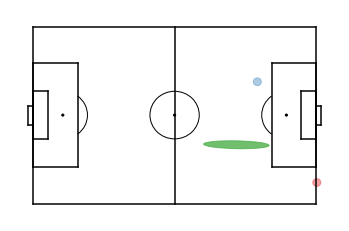

out 4


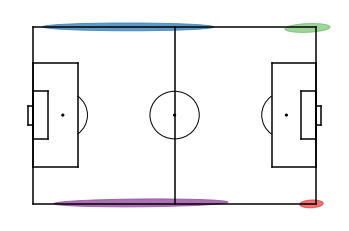

goal 1


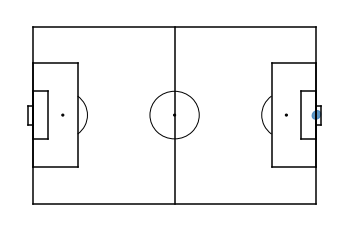

cross 2


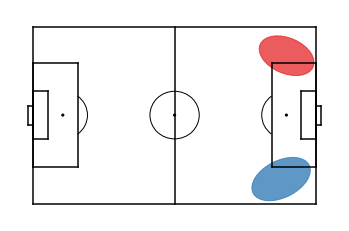

shot_penalty 1


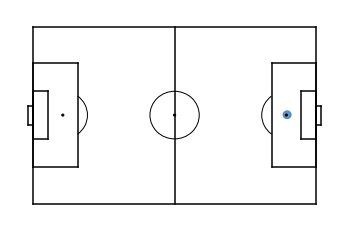

yellow_card 1


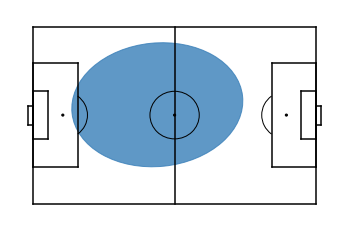

bad_touch 1


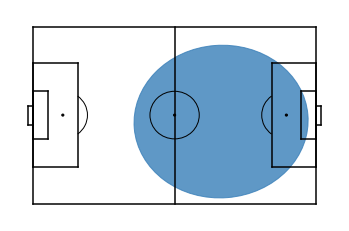

receival 7


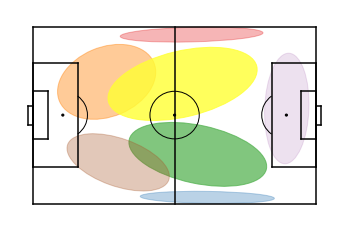

clearance 1


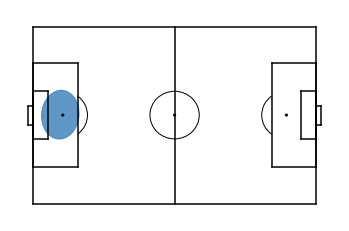

interception 2


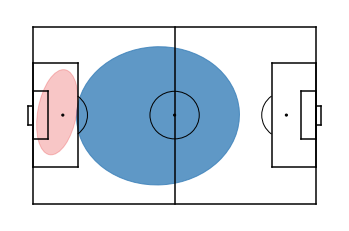

take_on 1


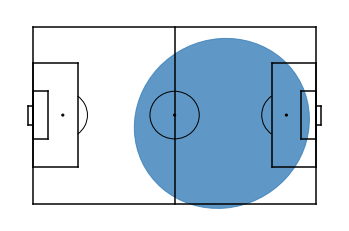

throw_in 2


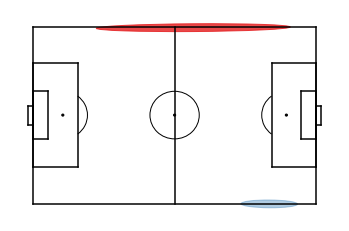

shot 1


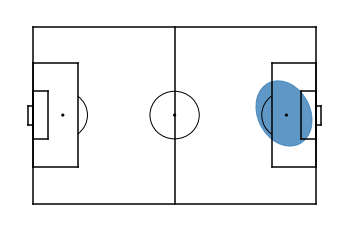

keeper_catch 1


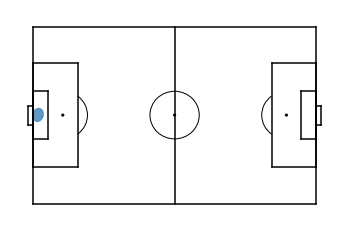

tackle 1


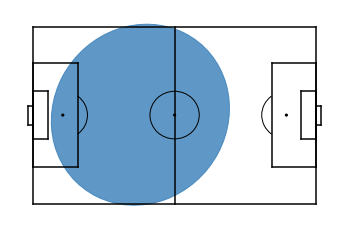

pass 5


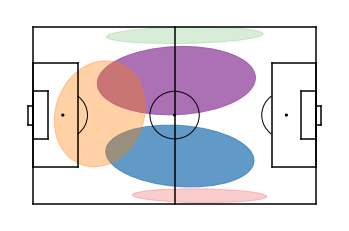

dribble 8


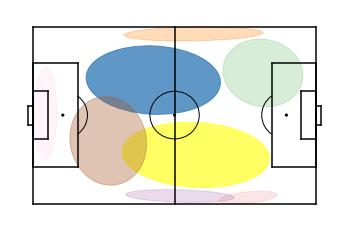

freekick 1


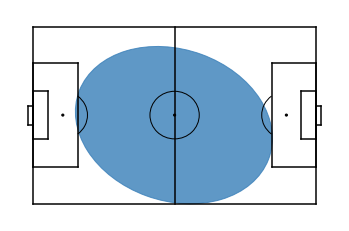

corner 2


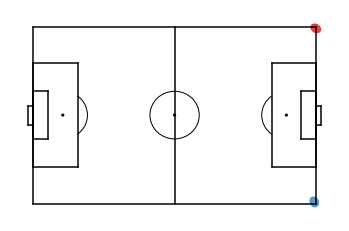

foul 1


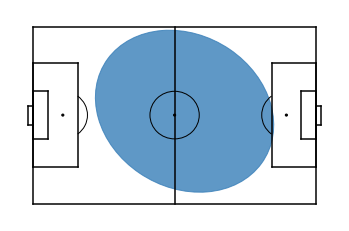

goalkick 1


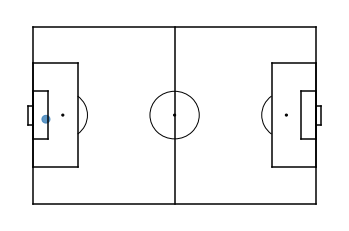

In [20]:
vis.show_location_models(list(mix.ilp_select_models_bic(loc_candidates)))

offside 1


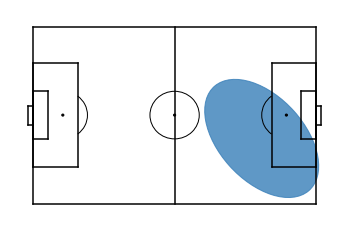

out 2


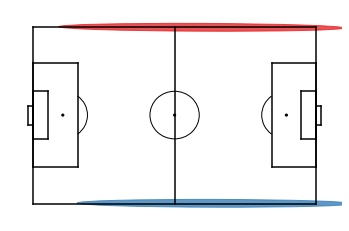

goal 1


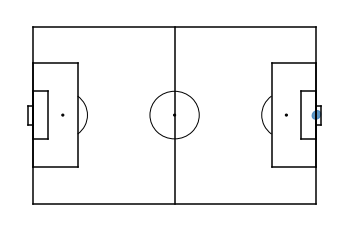

cross 1


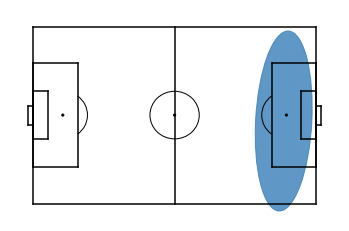

shot_penalty 1


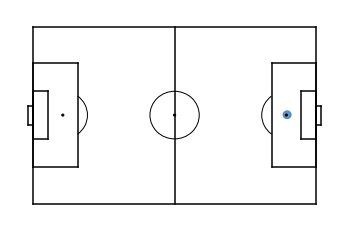

yellow_card 1


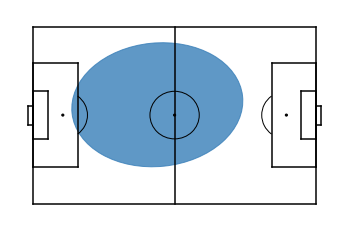

bad_touch 1


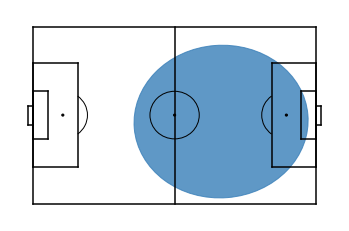

receival 4


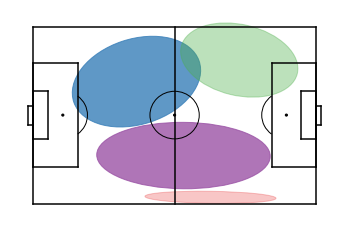

clearance 1


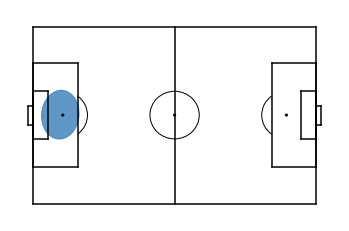

interception 1


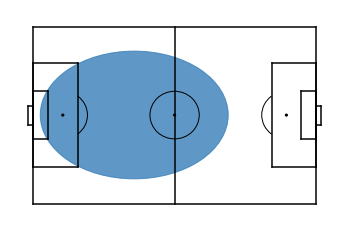

take_on 1


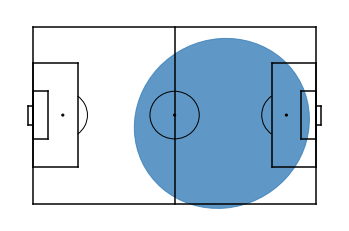

throw_in 2


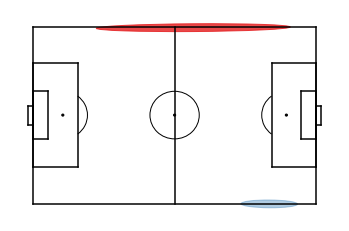

shot 1


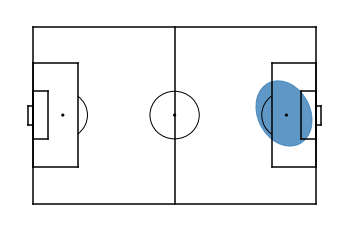

keeper_catch 1


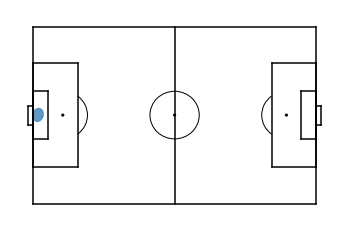

tackle 1


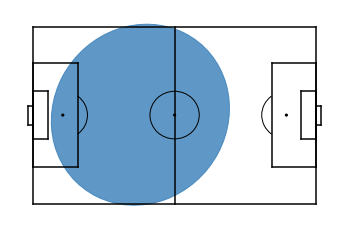

pass 3


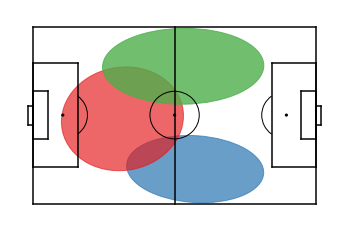

dribble 3


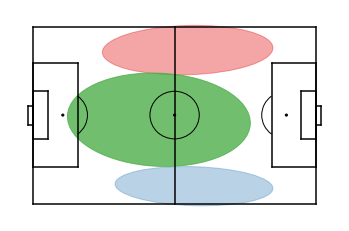

freekick 1


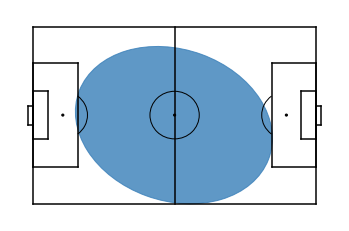

corner 1


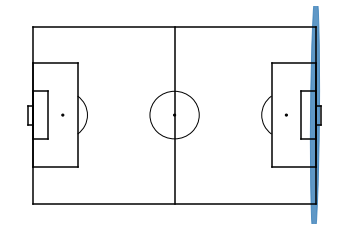

foul 1


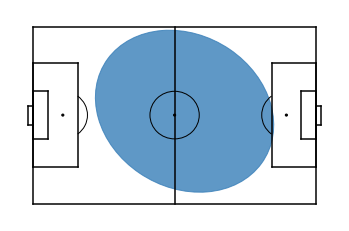

goalkick 1


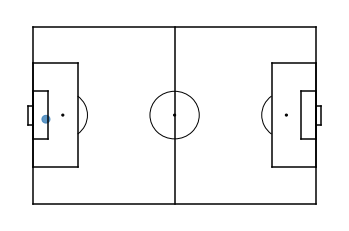

In [21]:
vis.show_location_models(list(mix.ilp_select_models_bic_triangle(loc_candidates)))

offside 4


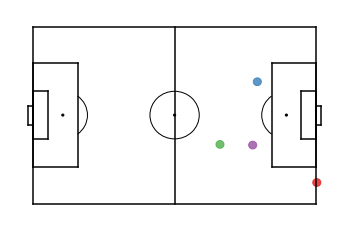

out 4


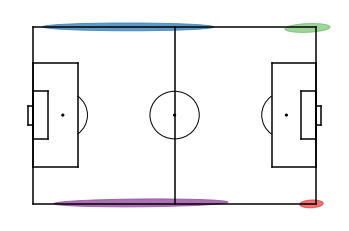

goal 1


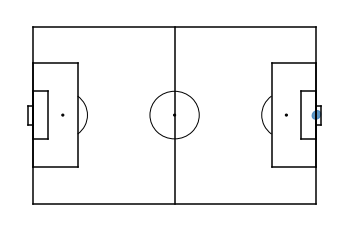

cross 2


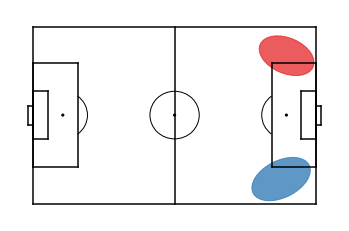

shot_penalty 9


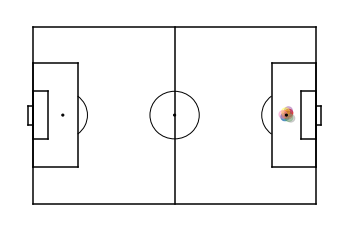

yellow_card 7


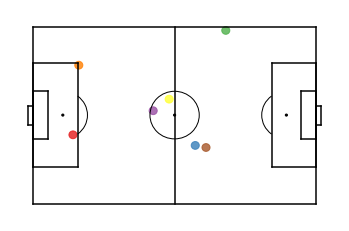

bad_touch 1


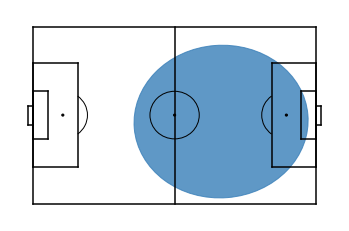

receival 7


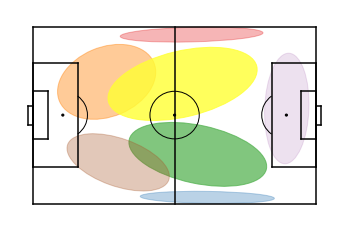

clearance 1


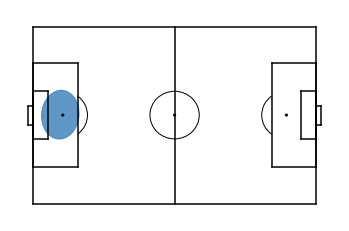

interception 3


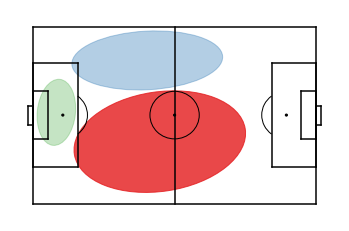

take_on 2


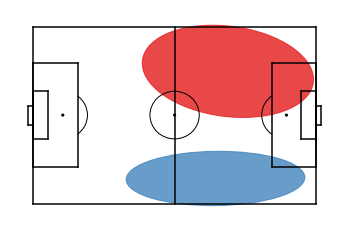

throw_in 2


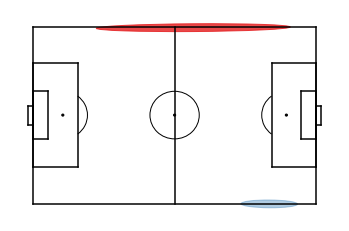

shot 2


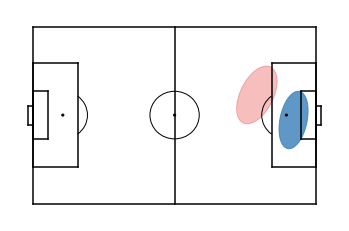

keeper_catch 7


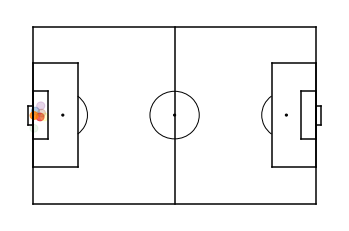

tackle 3


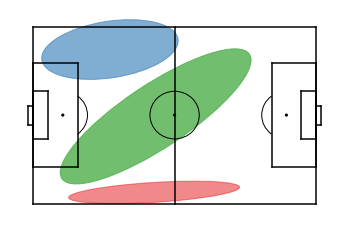

pass 5


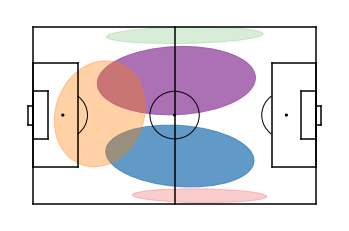

dribble 8


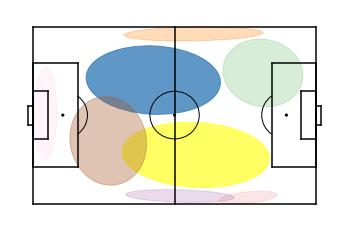

freekick 3


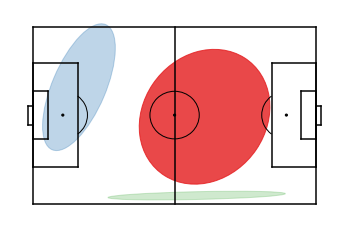

corner 8


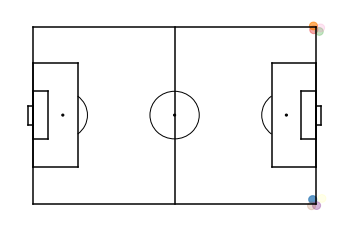

foul 1


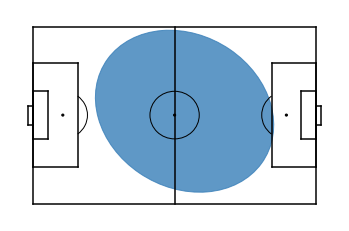

goalkick 1


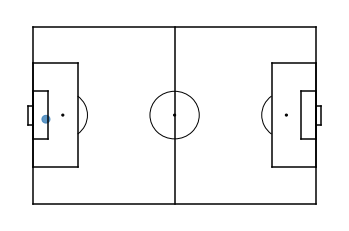

In [22]:
vis.show_location_models(list(mix.select_models_solo_bic(loc_candidates)))

## Optimize number of clusters

In [23]:
for m in loc_candidates:
    m.solo_bic = np.log(m.weight_total) * m._n_parameters() - 2*m.loglikelihood
    print(m.name, m.n_components, m.solo_bic)

offside 1 63.570788523690965
offside 2 30.574188148585492
offside 3 -33.637165627573296
offside 4 -59.77741454332228
out 1 1850.9559268595758
out 2 1340.7520919451076
out 3 1345.669972714286
out 4 1284.5793951069336
out 5 1295.3990232892806
out 6 1313.839407958228
out 7 1333.1214521784395
out 8 1338.1408544379149
out 9 1317.5173357342853
goal 1 137.07157428891264
goal 2 146.3789804167555
goal 3 155.64644854048146
goal 4 174.5984019824804
goal 5 184.43661864375065
goal 6 159.09244339468162
goal 7 162.50810933682112
goal 8 170.57880407468593
goal 9 145.3280224419967
cross 1 1363.9202224286548
cross 2 1245.2092442892358
cross 3 1254.4770232734038
cross 4 1270.7190706532992
cross 5 1286.8996613045517
cross 6 1298.5020481641964
cross 7 1319.8744772184289
cross 8 1335.7326694225028
cross 9 1353.4595526755322
shot_penalty 1 57.530426674539996
shot_penalty 2 57.81643454950567
shot_penalty 3 77.8884153236205
shot_penalty 4 43.55186708073245
shot_penalty 5 14.942928105219053
shot_penalty 6 -7.16

dribble
8


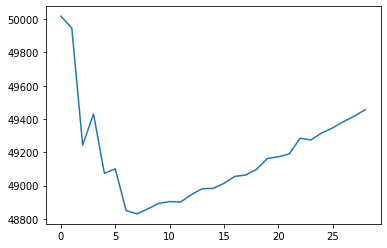

pass
5


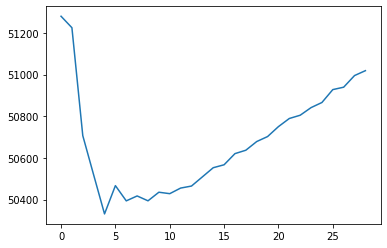

receival
7


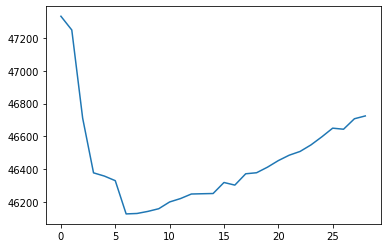

interception
3


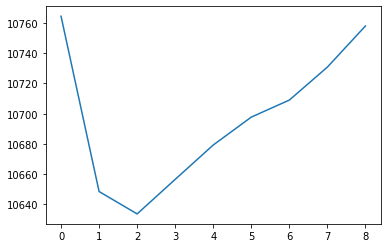

clearance
1


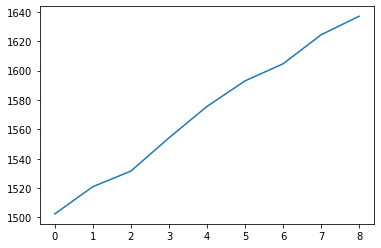

foul
1


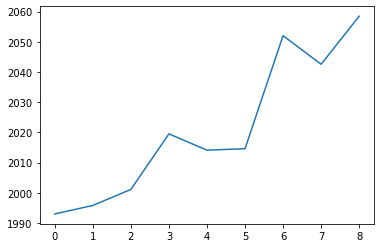

out
4


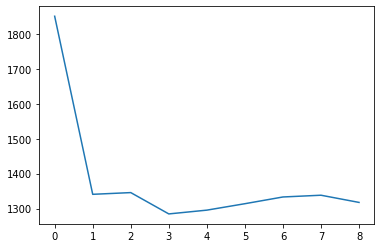

throw_in
2


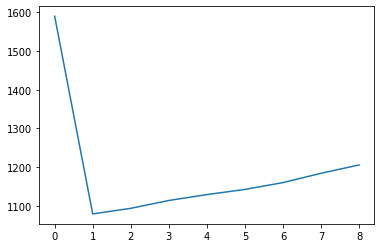

tackle
3


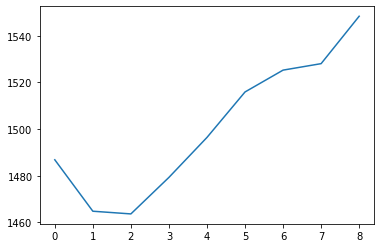

cross
2


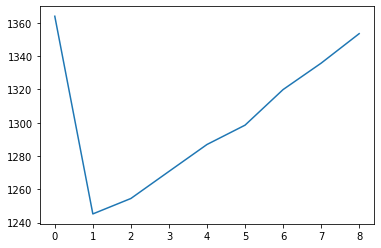

shot
2


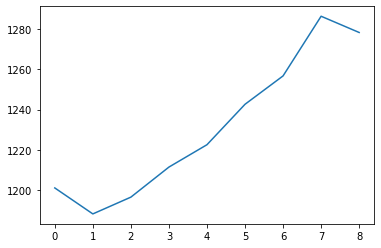

goalkick
1


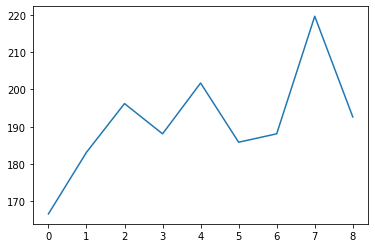

bad_touch
1


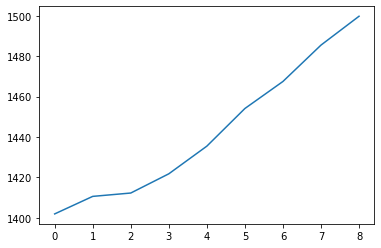

freekick
3


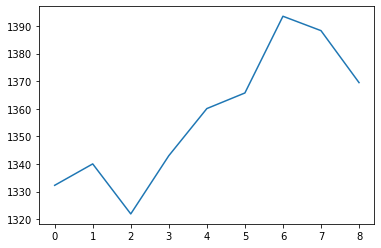

keeper_catch
7


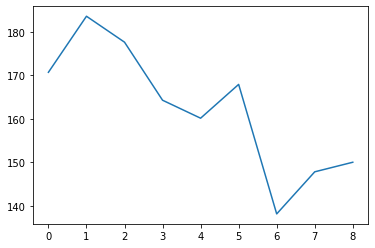

take_on
2


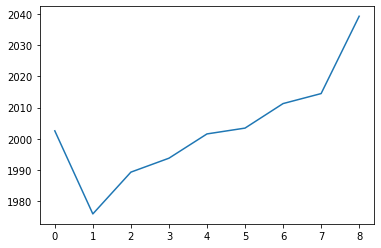

goal
1


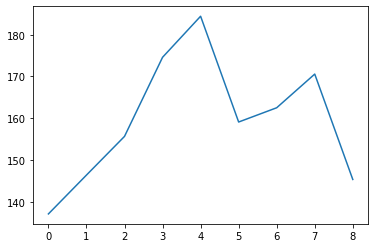

corner
8


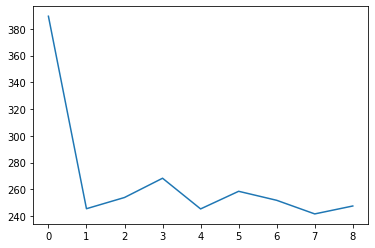

yellow_card
7


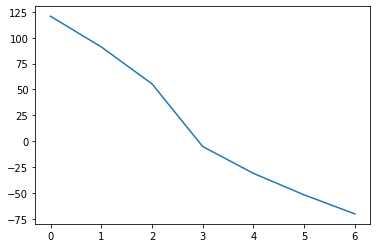

offside
4


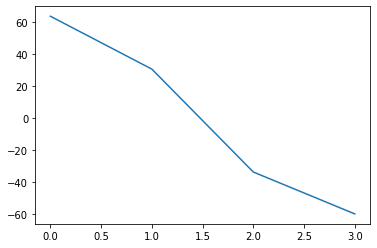

shot_penalty
9


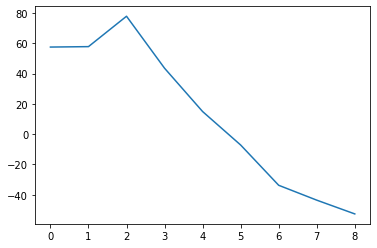

In [24]:
for l in a["type_name"].unique():
    bic_scores = []
    for m in loc_candidates:
        if (m.name == l):
            bic_scores.append(m.solo_bic)
            
    print(l)
    print(np.argmin(bic_scores)+1)
    plt.figure()
    plt.plot(range(0,len(bic_scores)), bic_scores)
    plt.show()

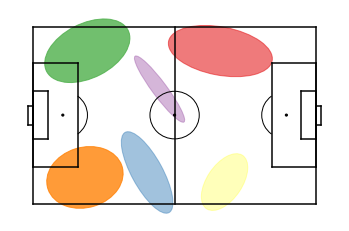

In [43]:
# visualize a specific location model
name = "tackle"
n_comp = 6

for m in loc_candidates:
    if ((m.name == name) & (m.n_components == n_comp)):
        model = m
        break
        
vis.show_location_model(model)

## Make selection

In [28]:
loc_ultimate_selection = [
    ("goal" , 1),
    ("red_card" , 1),
    ("shot", 1),
    ("receival", 6), 
    ("keeper_catch", 6),
    ("goalkick" , 1),
    ("foul" , 1), 
    ("offside", 1),
    ("dribble", 7), 
    ("yellow_card", 3),
    ("corner", 2),
    ("cross" , 2),
    ("bad_touch", 1),
    ("take_on", 1),
    ("tackle" , 2),
    ("shot_penalty", 1),
    ("freekick", 2),
    ("owngoal", 1),
    ("throw_in", 2),
    ("clearance", 1),
    ("out", 4),
    ("pass", 4),
    ("interception", 2)
]

In [29]:
loc_models = [l for l in loc_candidates if ((l.name,l.n_components) in loc_ultimate_selection)]

offside 1


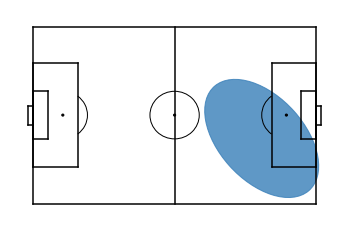

out 4


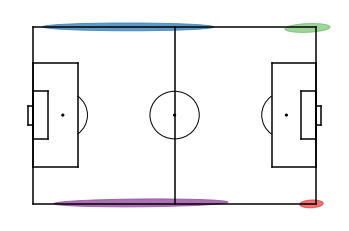

goal 1


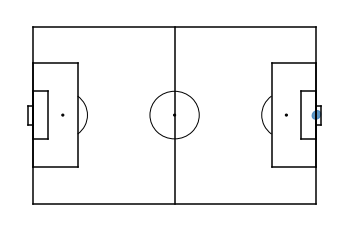

cross 2


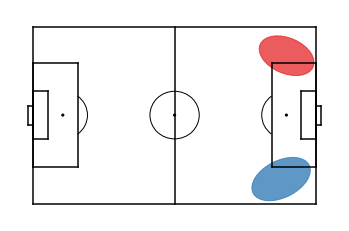

shot_penalty 1


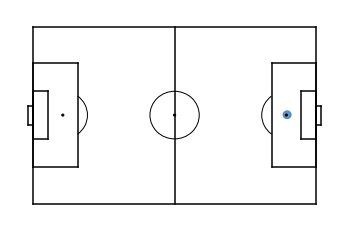

yellow_card 3


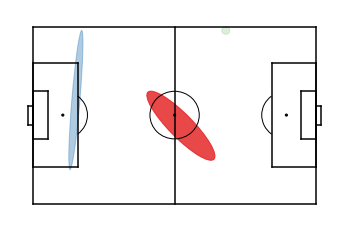

bad_touch 1


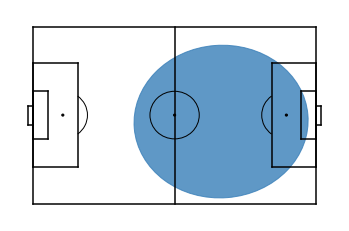

receival 6


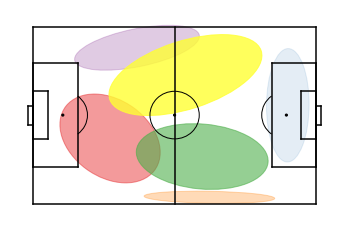

clearance 1


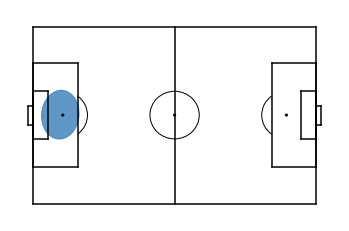

interception 2


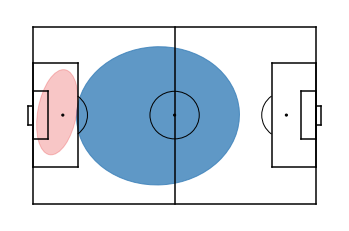

take_on 1


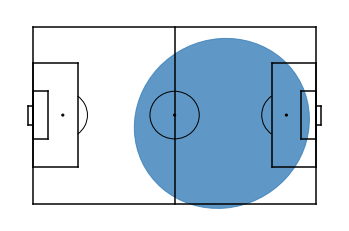

throw_in 2


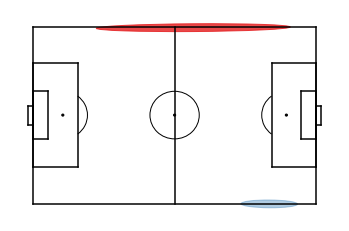

shot 1


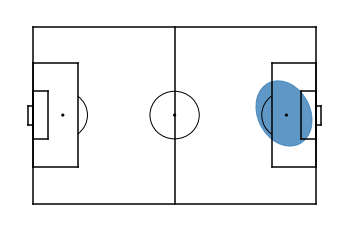

keeper_catch 6


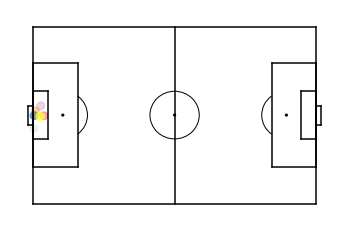

tackle 2


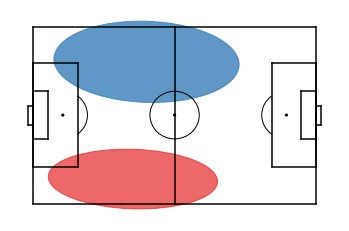

pass 4


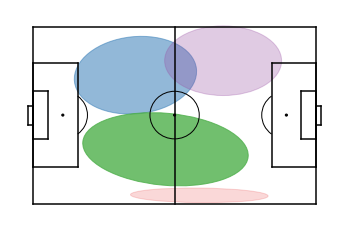

dribble 7


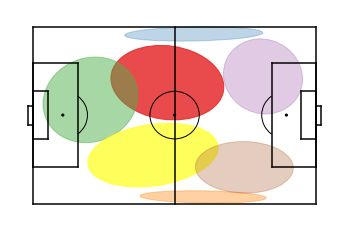

freekick 2


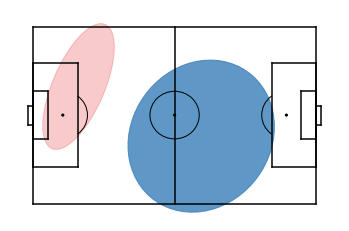

corner 2


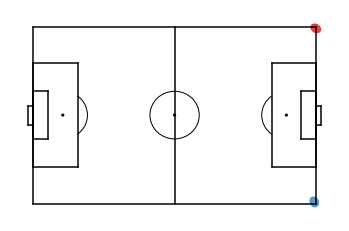

foul 1


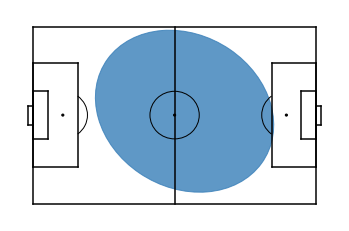

goalkick 1


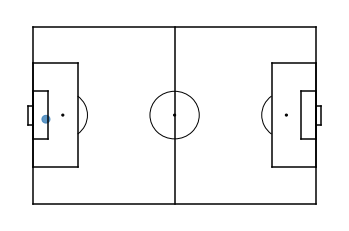

In [30]:
vis.show_location_models(loc_models)

In [31]:
loc_weights = mix.probabilities(loc_models,a[["x","y"]],cat_weights)

## Save Categorical and Location models

In [32]:
import pickle

file = open('../data/soccermix_fifa_models.pkl', 'wb')
pickle.dump(cat_model, file)
pickle.dump(loc_models, file)
file.close()


file2 = open('../data/soccermix_fifa_candidates.pkl', 'wb')
pickle.dump(loc_candidates, file2)
file2.close()


data = '../data/soccermix_fifa_data.h5'
a.to_hdf(data, 'X')


data1 = open('../data/soccermix_fifa_catweights.pkl', 'wb') 
s_cat_weights = cat_weights.astype(pd.SparseDtype("float", 0.0))
s_cat_weights.to_pickle(data1)
data1.close()


data2 = open('../data/soccermix_fifa_locweights.pkl', 'wb') 
s_loc_weights = loc_weights.astype(pd.SparseDtype("float", 0.0))
s_loc_weights.to_pickle(data2)
data2.close()

## Direction models

In [33]:
experiments = [dict(name=name,n_components=i,distribution=mix.VonMises)
               for name in loc_weights.columns
               for i in range(1,10)]
len(experiments)

459

In [34]:
experiments

[{'name': 'offside_0', 'n_components': 1, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 2, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 3, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 4, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 5, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 6, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 7, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 8, 'distribution': mixture.VonMises},
 {'name': 'offside_0', 'n_components': 9, 'distribution': mixture.VonMises},
 {'name': 'out_0', 'n_components': 1, 'distribution': mixture.VonMises},
 {'name': 'out_0', 'n_components': 2, 'distribution': mixture.VonMises},
 {'name': 'out_0', 'n_components': 3, 'distribution': mixture.VonMises},
 {'name': 'out_0', 'n_components': 4, 'distribution': mixture.VonMises},
 {'name': 'out_

In [35]:
X = a[["mov_angle_a0"]]
dir_candidates = learn_mixture_models(X,loc_weights,experiments)
len(dir_candidates)


100%|██████████| 459/459 [02:08<00:00,  3.57it/s]


414

## Save Direction candidates

In [36]:
with open('../data/soccermix_fifa_candidates.pkl','ab') as wfp:
    pickle.dump(dir_candidates, wfp)

## Inspect with strategies

offside 1


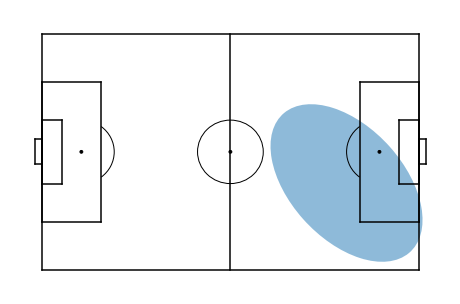

out 4


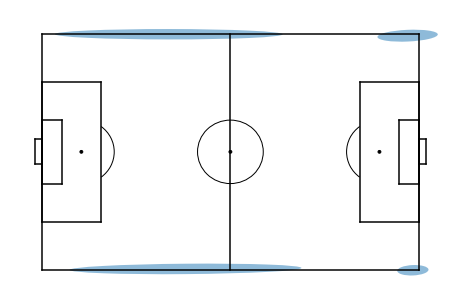

goal 1


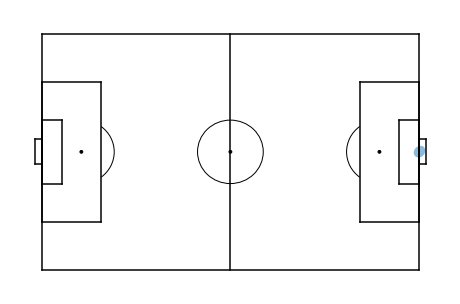

cross 2


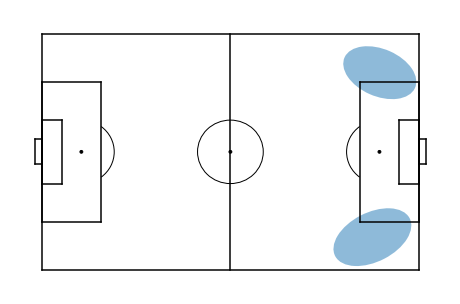

shot_penalty 1


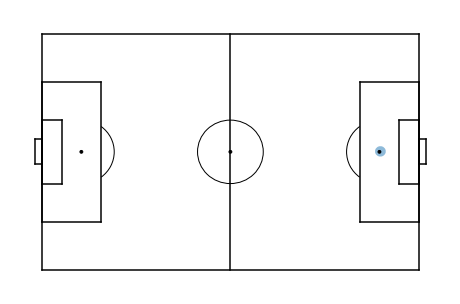

yellow_card 3


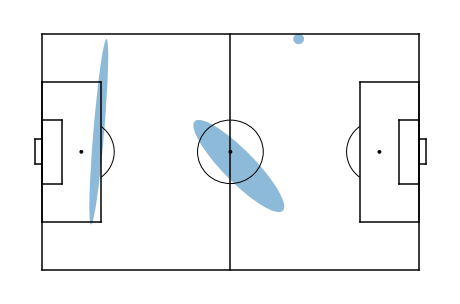

bad_touch 1


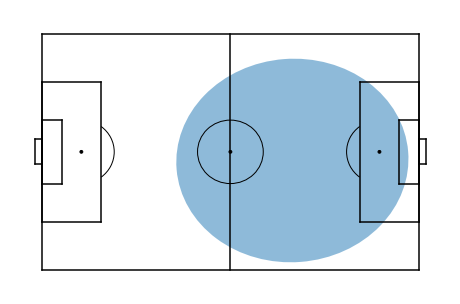

receival 6


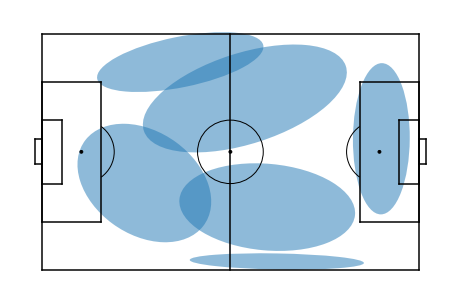

clearance 1


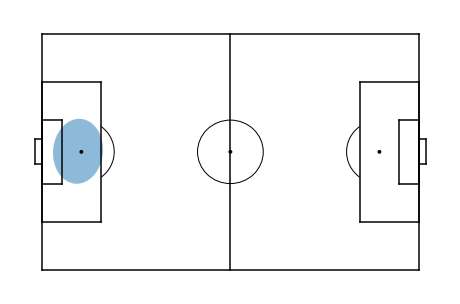

interception 2


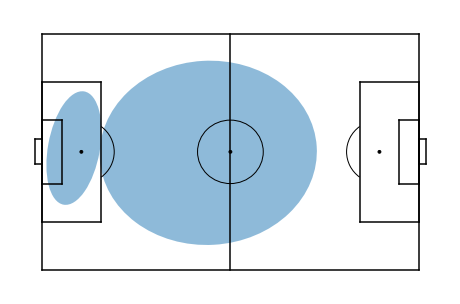

take_on 1


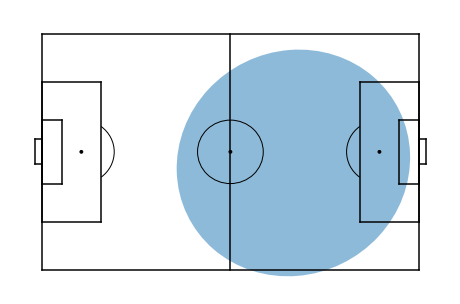

throw_in 2


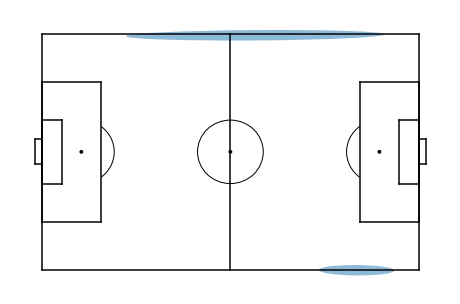

shot 1


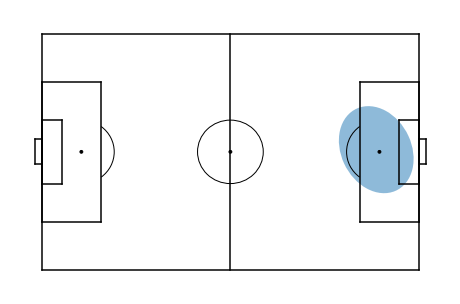

keeper_catch 6


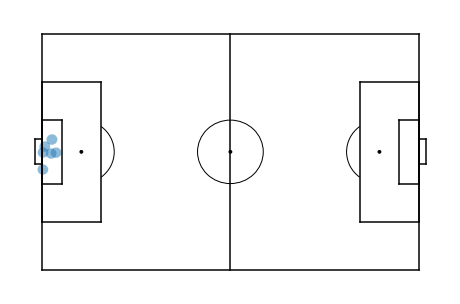

tackle 2


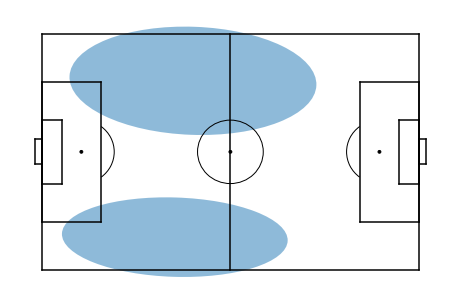

pass 4


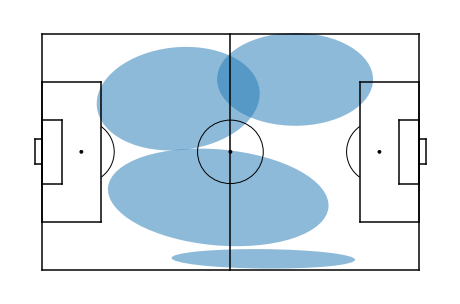

dribble 7


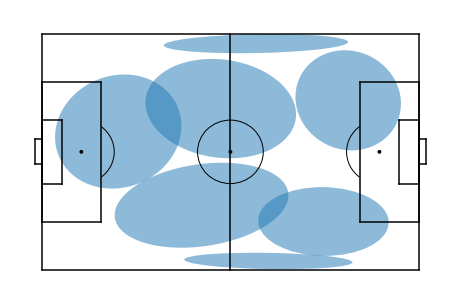

freekick 2


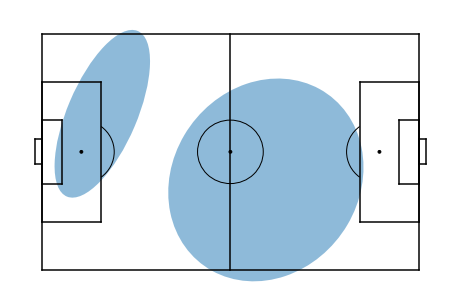

corner 2


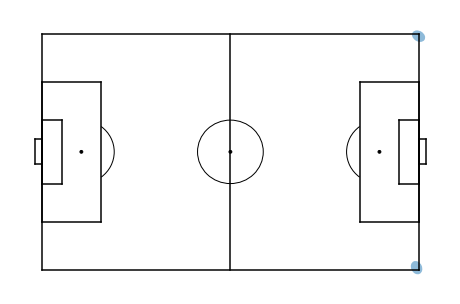

foul 1


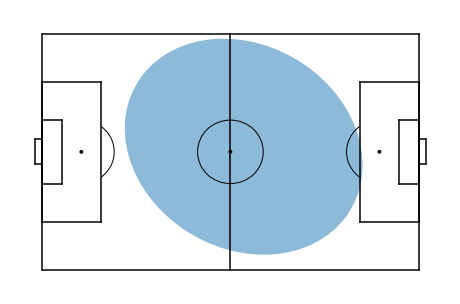

goalkick 1


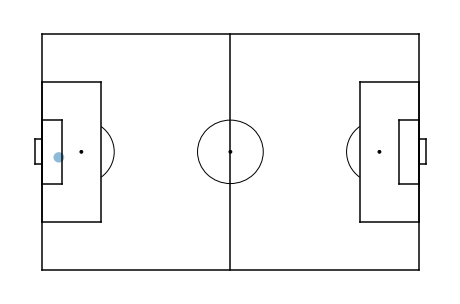

In [37]:
vis.show_all_models(loc_models,list(mix.ilp_select_models_bic_triangle(dir_candidates)))

offside 1


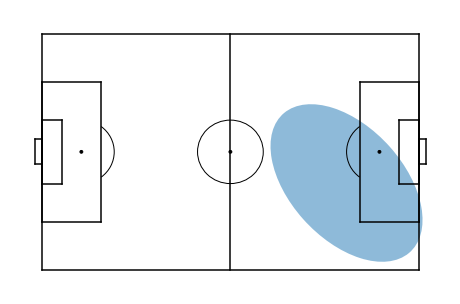

out 4


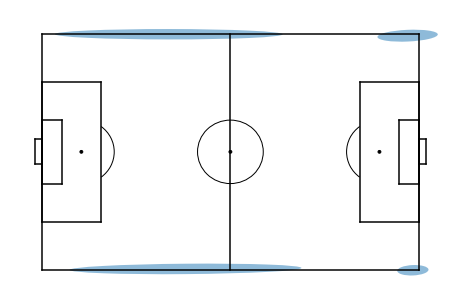

goal 1


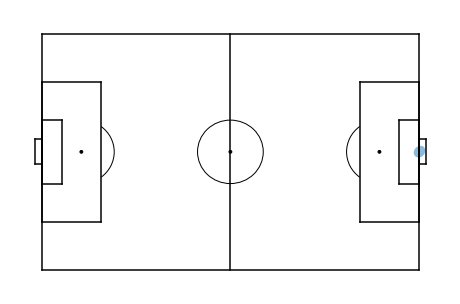

cross 2


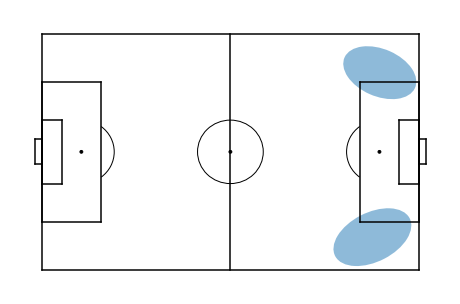

shot_penalty 1


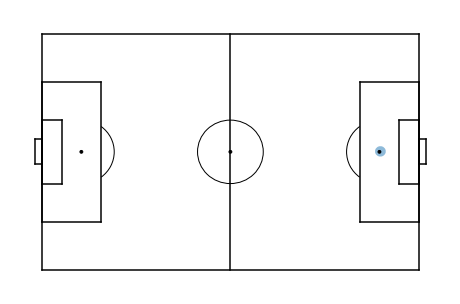

yellow_card 3


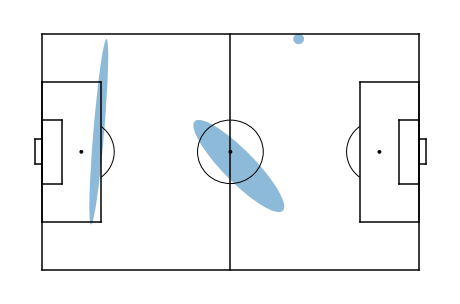

bad_touch 1


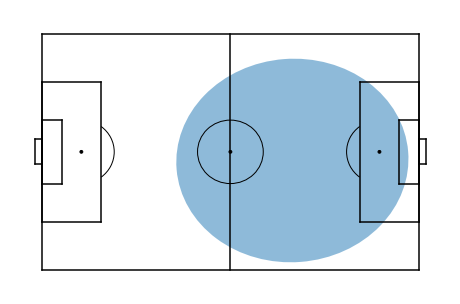

receival 6


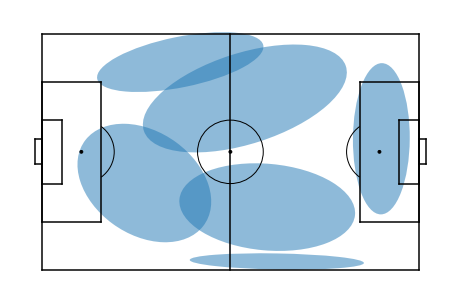

clearance 1


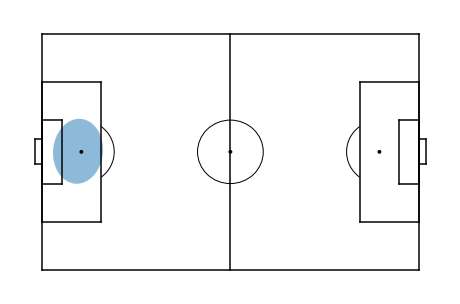

interception 2
interception_0 1
interception_1 2


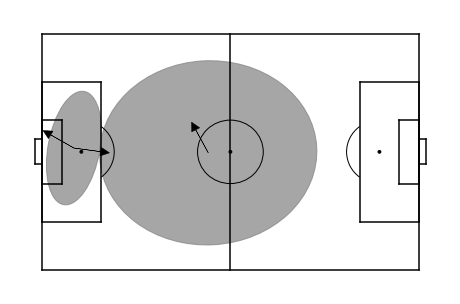

take_on 1


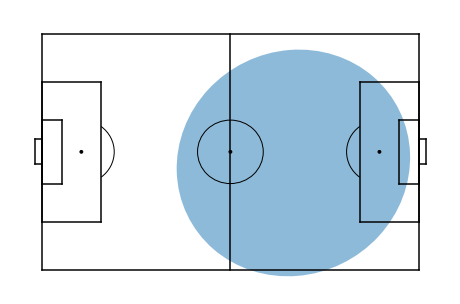

throw_in 2
throw_in_0 1
throw_in_1 2


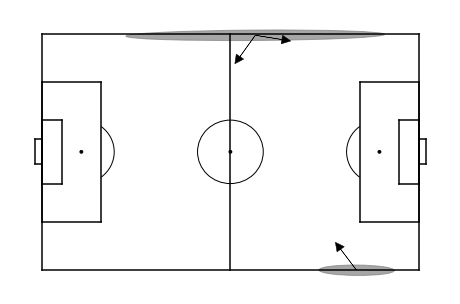

shot 1


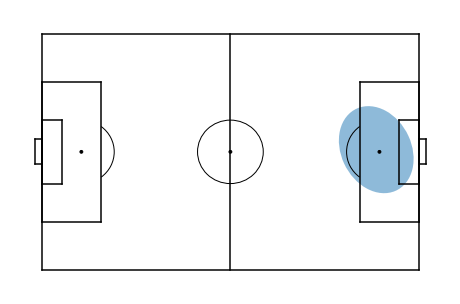

keeper_catch 6


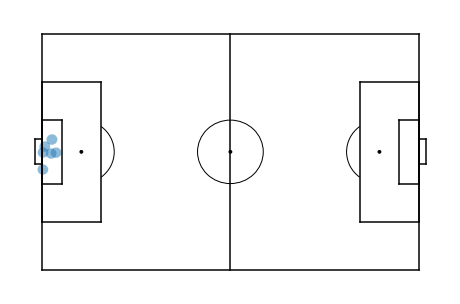

tackle 2


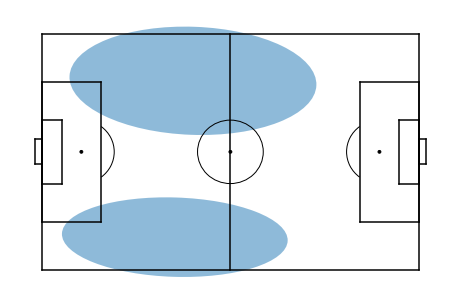

pass 4
pass_0 4
pass_1 2
pass_2 3
pass_3 3


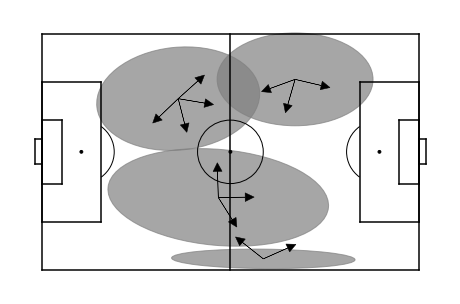

dribble 7
dribble_0 2
dribble_1 2
dribble_2 2
dribble_3 1
dribble_4 2
dribble_5 3
dribble_6 2


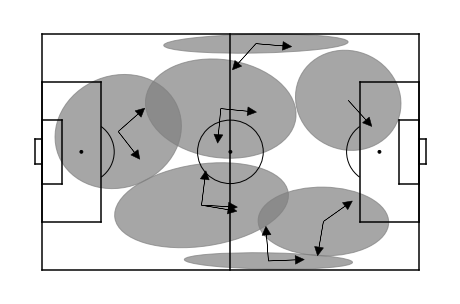

freekick 2
freekick_0 1
freekick_1 2


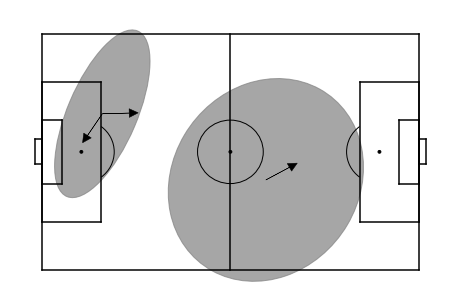

corner 2


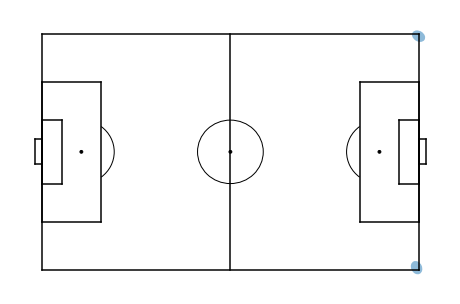

foul 1


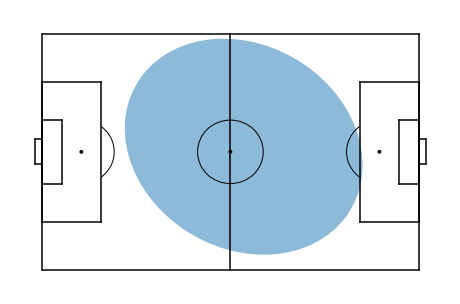

goalkick 1


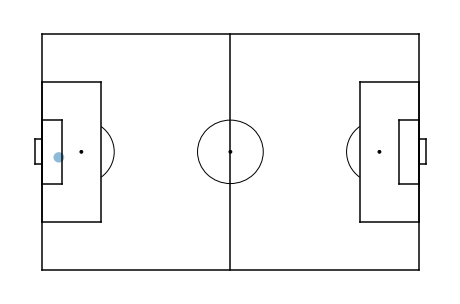

In [38]:
vis.show_all_models(loc_models, list(mix.ilp_select_models_bic(dir_candidates)))

offside 1
offside_0 2


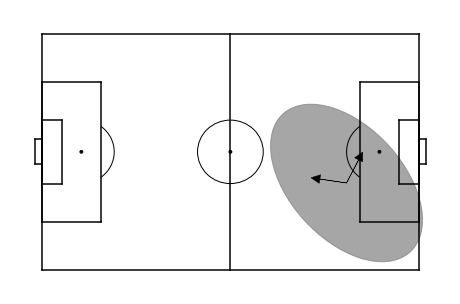

out 4
out_0 1
out_1 2
out_2 1
out_3 3


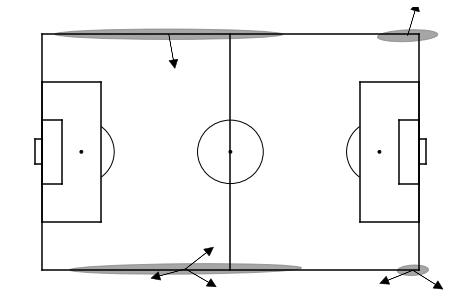

goal 1


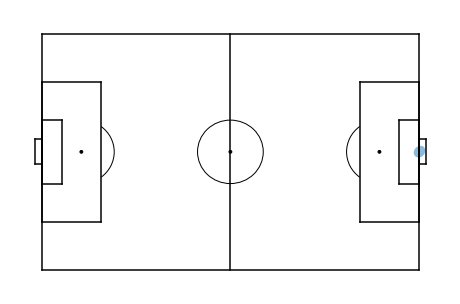

cross 2


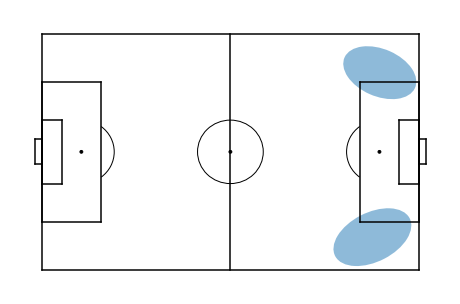

shot_penalty 1


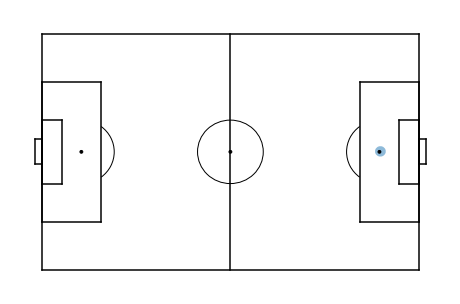

yellow_card 3
yellow_card_0 2
yellow_card_1 2
yellow_card_2 1


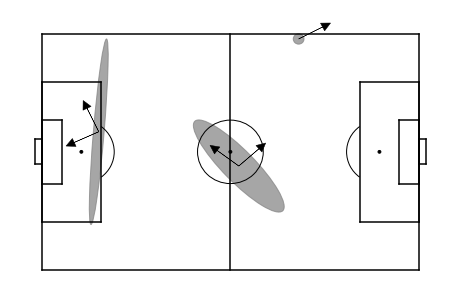

bad_touch 1


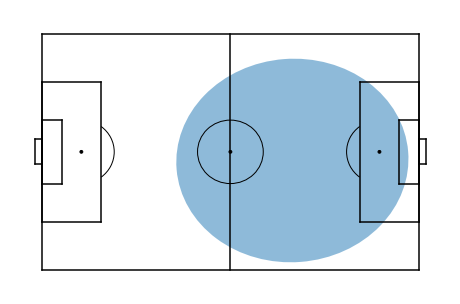

receival 6
receival_0 4
receival_1 1
receival_2 1
receival_3 1
receival_4 1
receival_5 1


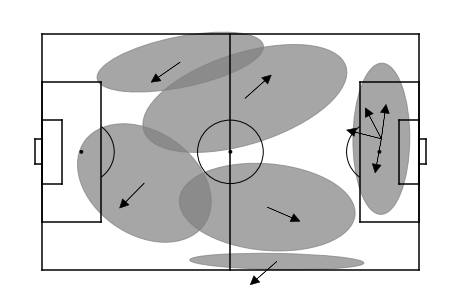

clearance 1


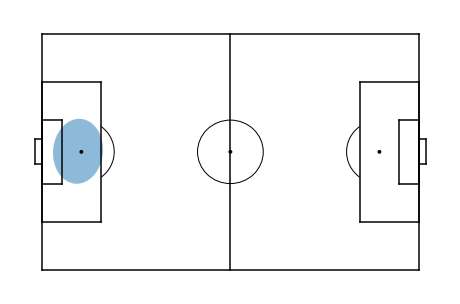

interception 2
interception_0 2
interception_1 2


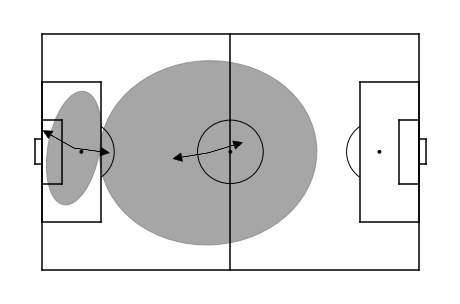

take_on 1


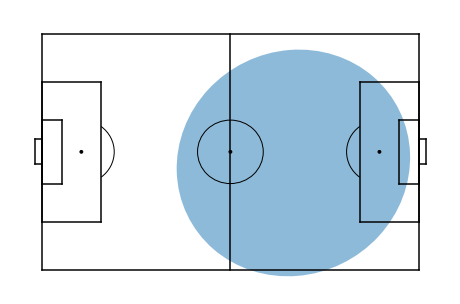

throw_in 2
throw_in_0 2
throw_in_1 3


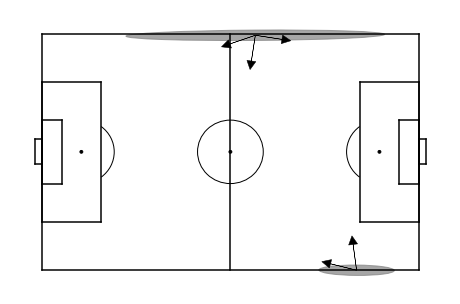

shot 1


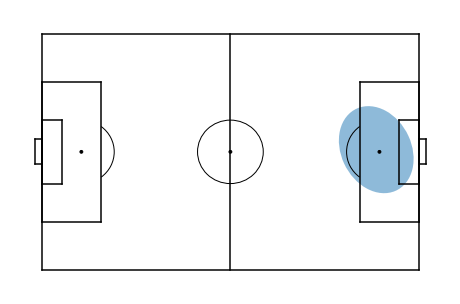

keeper_catch 6
keeper_catch_0 4
keeper_catch_1 3
keeper_catch_2 1
keeper_catch_3 2
keeper_catch_4 4
keeper_catch_5 3


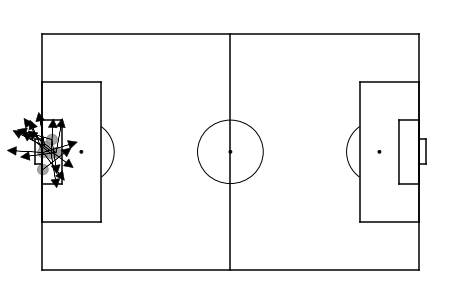

tackle 2


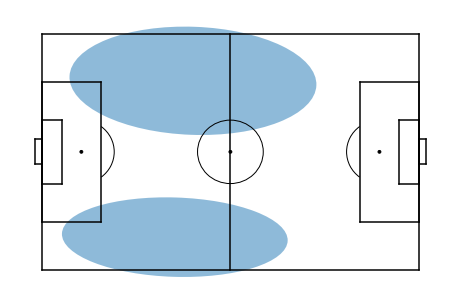

pass 4
pass_0 6
pass_1 2
pass_2 3
pass_3 3


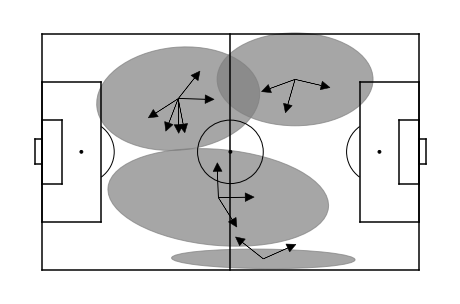

dribble 7
dribble_0 2
dribble_1 2
dribble_2 2
dribble_3 3
dribble_4 4
dribble_5 3
dribble_6 2


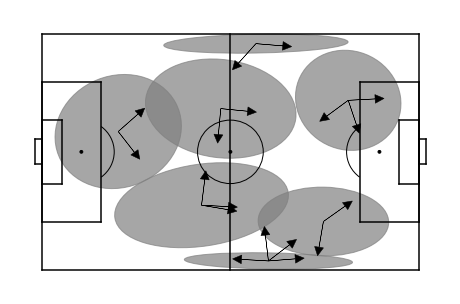

freekick 2
freekick_0 1
freekick_1 2


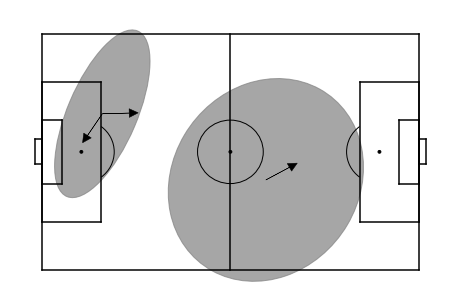

corner 2


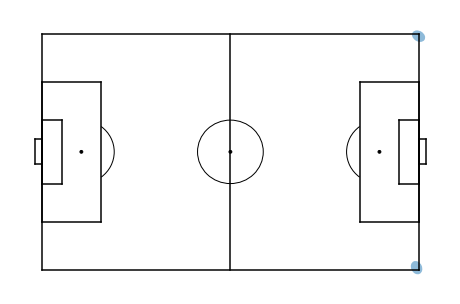

foul 1


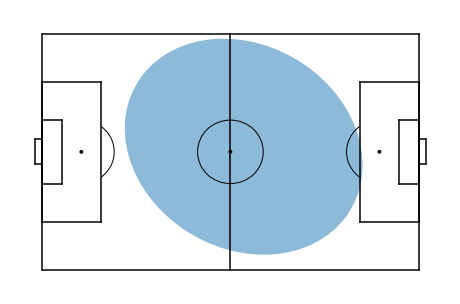

goalkick 1
goalkick_0 2


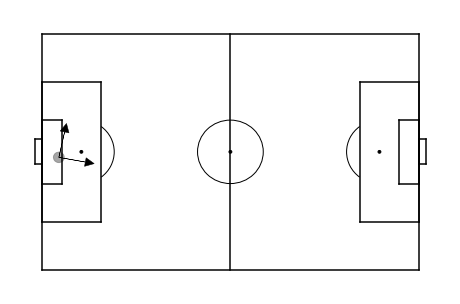

In [39]:
vis.show_all_models(loc_models,list(mix.select_models_solo_bic(dir_candidates)))

## Optimize # directions

In [40]:
for m in dir_candidates:
    m.solo_bic = np.log(m.weight_total) * m._n_parameters() - 2*m.loglikelihood
    print(m.name, m.n_components, m.solo_bic)

offside_0 1 9.996934856980554
offside_0 2 1.9252855012999643
offside_0 3 4.6937976550233635
offside_0 4 7.466346164544506
out_0 1 156.68488383845406
out_0 2 163.23549242272094
out_0 3 168.3519971616952
out_0 4 167.15830882049028
out_0 5 165.5706516707845
out_0 6 171.84639613742215
out_0 7 177.2430709659932
out_0 8 181.2766601680599
out_0 9 187.10854244318674
out_1 1 79.21869262596219
out_1 2 78.55050926671962
out_1 3 78.7104116404132
out_1 4 79.53675379872485
out_1 5 82.70038072014489
out_1 6 87.46452819592128
out_1 7 91.59971167342742
out_1 8 96.81911262004596
out_1 9 102.02370802476094
out_2 1 71.27675509357472
out_2 2 76.03002711699843
out_2 3 79.8094217366727
out_2 4 79.67538955596984
out_2 5 82.77650964898288
out_2 6 85.52939011296577
out_2 7 88.2963537153734
out_2 8 92.54377592026407
out_2 9 97.9557504375536
out_3 1 172.9179588603734
out_3 2 166.9511841238269
out_3 3 161.62036149400535
out_3 4 165.56181355799114
out_3 5 168.66606673866326
out_3 6 174.12374654246142
out_3 7 178.84

offside 0
2


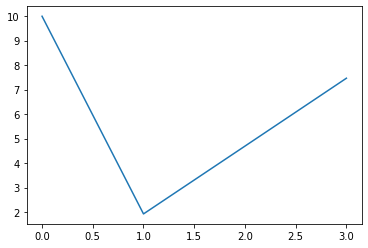

out 0
1


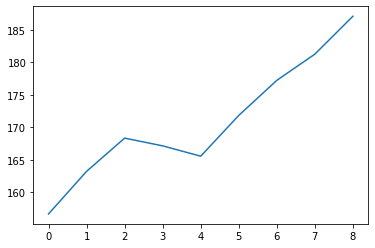

out 1
2


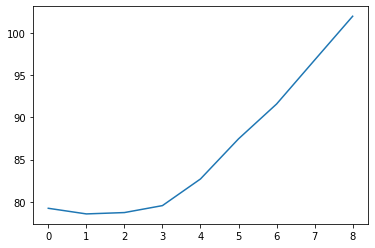

out 2
1


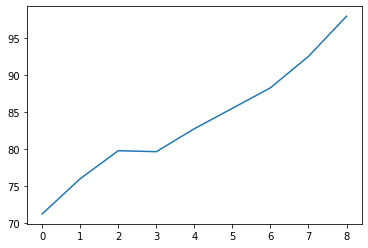

out 3
3


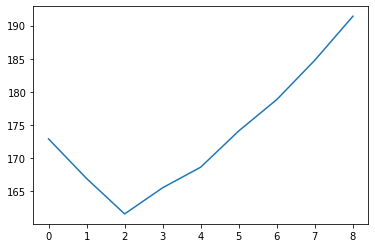

goal 0
1


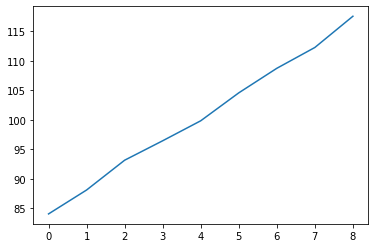

cross 0
1


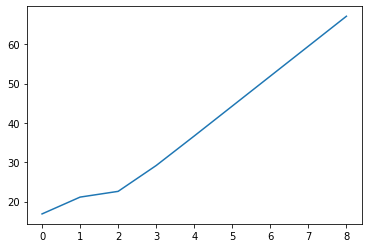

cross 1
1


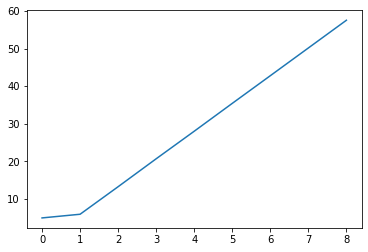

shot_penalty 0
1


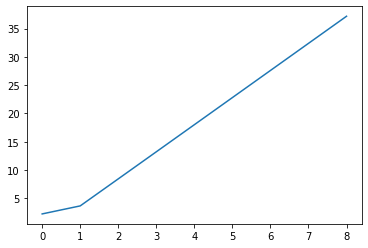

yellow_card 0
2


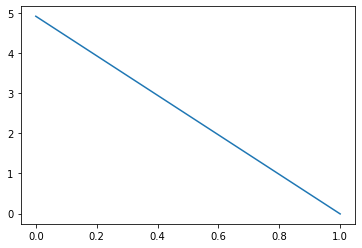

yellow_card 1
2


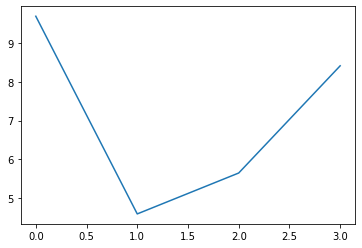

yellow_card 2
1


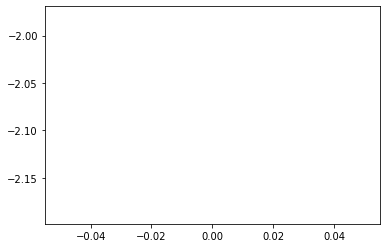

bad_touch 0
1


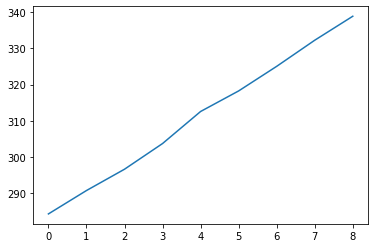

receival 0
4


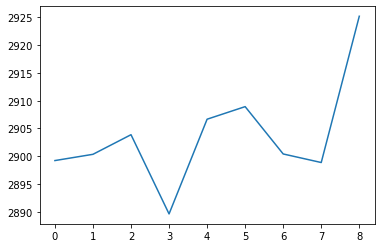

receival 1
1


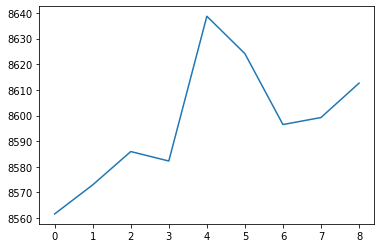

receival 2
1


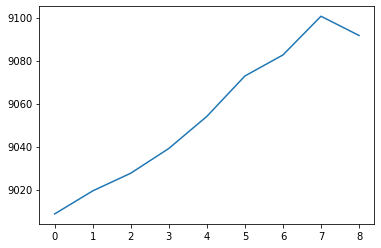

receival 3
1


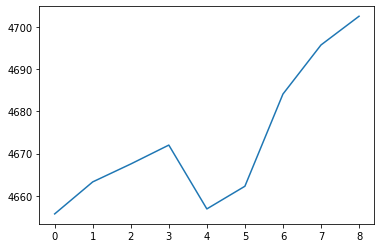

receival 4
1


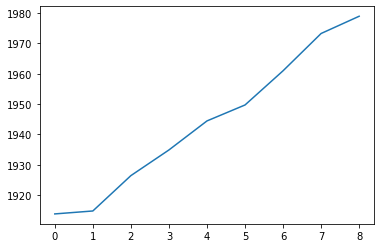

receival 5
1


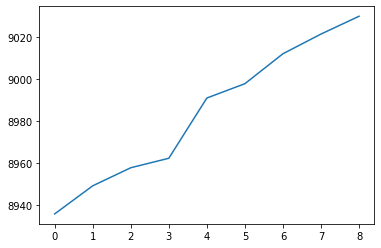

clearance 0
1


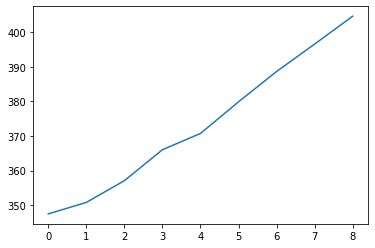

interception 0
2


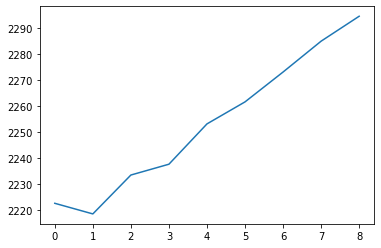

interception 1
2


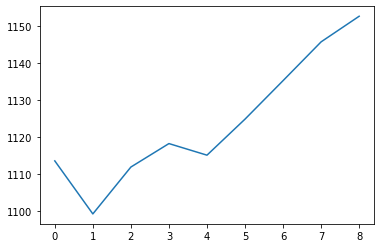

take_on 0
1


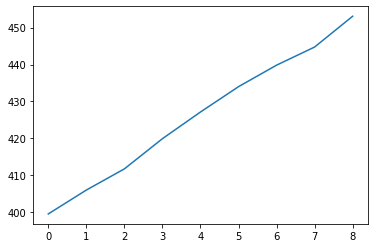

throw_in 0
2


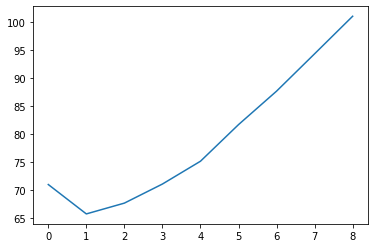

throw_in 1
3


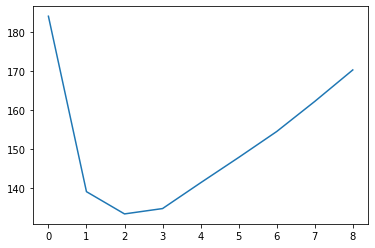

shot 0
1


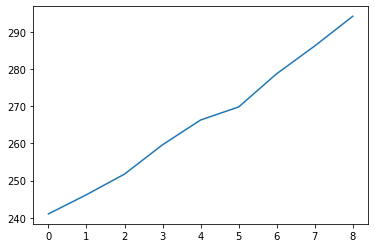

keeper_catch 0
4


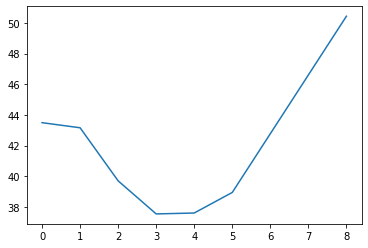

keeper_catch 1
3


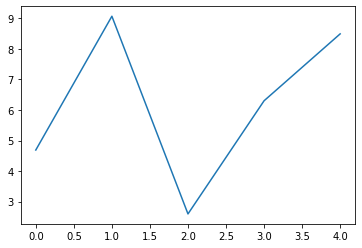

keeper_catch 2
1


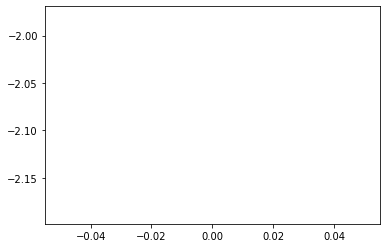

keeper_catch 3
2


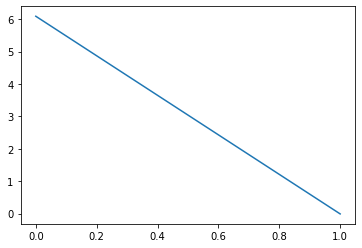

keeper_catch 4
4


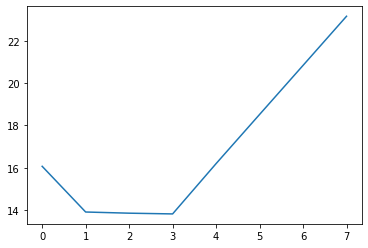

keeper_catch 5
3


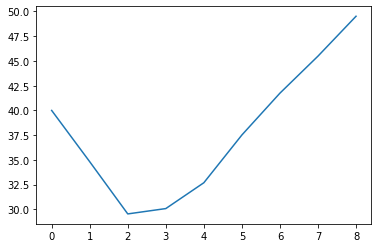

tackle 0
1


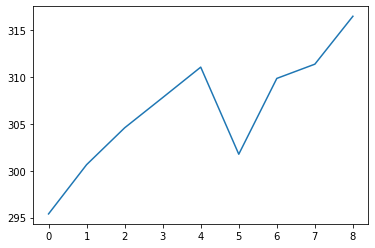

tackle 1
1


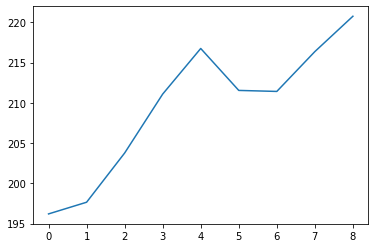

pass 0
6


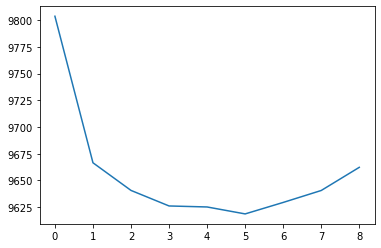

pass 1
2


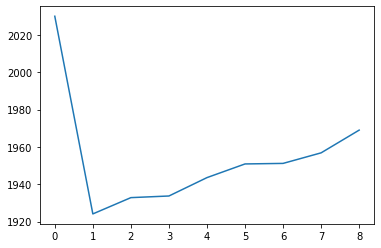

pass 2
3


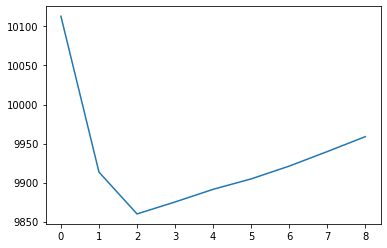

pass 3
3


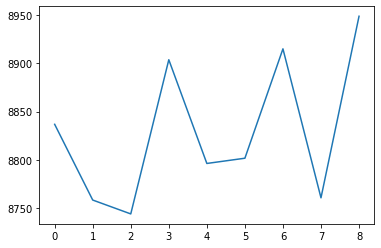

dribble 0
2


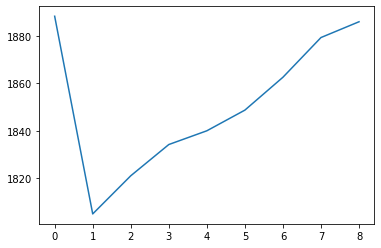

dribble 1
2


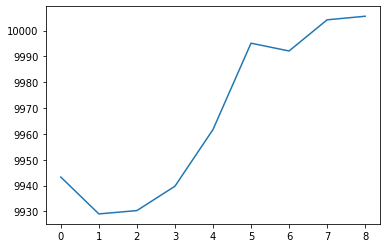

dribble 2
2


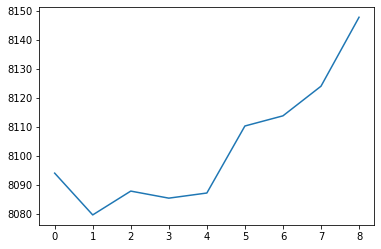

dribble 3
3


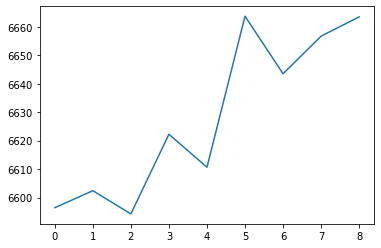

dribble 4
4


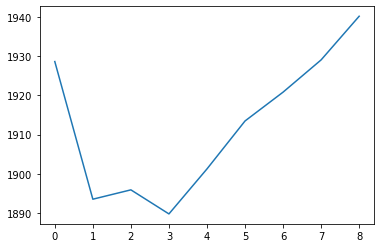

dribble 5
3


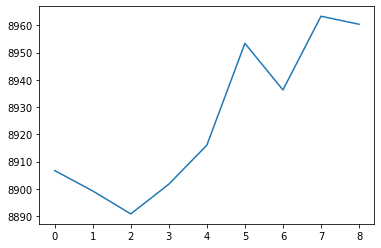

dribble 6
2


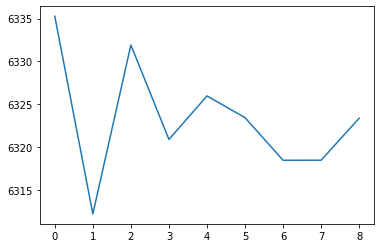

freekick 0
1


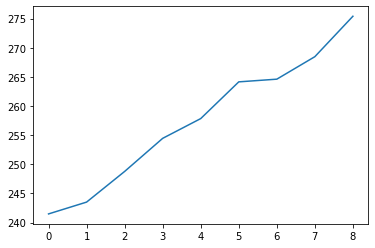

freekick 1
2


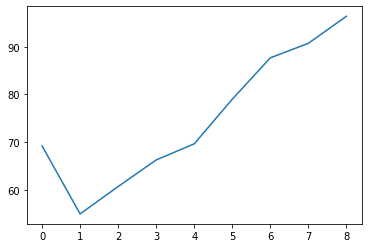

corner 0
1


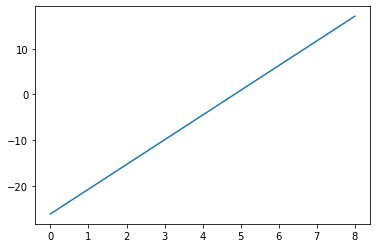

corner 1
1


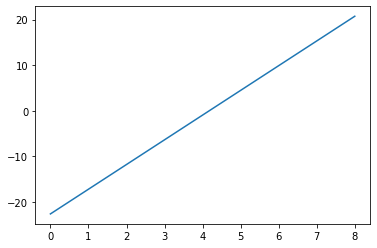

foul 0
1


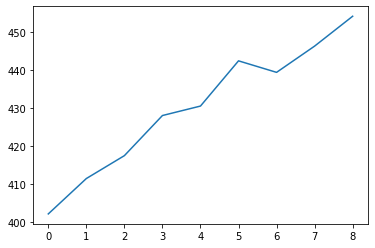

goalkick 0
2


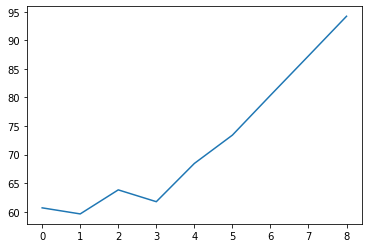

In [41]:
for l in loc_models:
    for i, gauss in enumerate(l.submodels):
        bic_scores = []
        for  m in dir_candidates:
            if f"{l.name}_{i}" == m.name:
                bic_scores.append(m.solo_bic)
            
        print(l.name, i)
        print(np.argmin(bic_scores)+1)
        plt.figure()
        plt.plot(range(0,len(bic_scores)), bic_scores)
        plt.show()

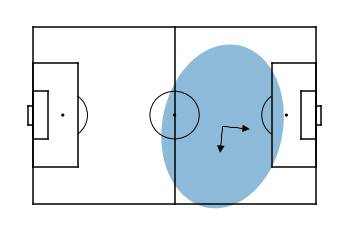

In [45]:
# visualize a specific direction model
name = "dribble"
loc_comp = 2
nb = 1
n_dir_comp = 2

for m in loc_candidates:
    if ((m.name == name) & (m.n_components == loc_comp)):
        for i, g in enumerate(m.submodels):
            if (i == nb):
                gauss = g
                model = m
                break
        else:
            continue
        break


for n in dir_candidates:
    if f"{model.name}_{nb}" == n.name:
        if len(n.submodels) == n_dir_comp:
            dirmod = n
            break

vis.show_direction_model(gauss, dirmod)

## Make selection

In [46]:
dir_selection = [
    ("offside_0", 1),
    ("goal_0" , 1),
    ("red_card_0" , 1),
    ("shot_0", 1),
    ("goalkick_0" , 1),
    ("corner_0", 1),
    ("corner_1", 1),
    ("cross_0" , 1),
    ("cross_1" , 1),
    ("shot_penalty_0", 1),
    ("freekick_0", 1),
    ("freekick_1", 1),
    ("owngoal_0", 1),
    ("clearance_0", 1)
]

dir_selection.extend([(f"receival_{nb}", 1) for nb in range(0,6)])
catch = [3,2,1,1,2]
dir_selection.extend([(f"keeper_catch_{nb}", catch[nb]) for nb in range(0,5)])
dir_selection.extend([(f"foul_{nb}", 1) for nb in range(0,1)])
                      
dribbles = [1,1,1,2,3,2,1]
dir_selection.extend([(f"dribble_{nb}", dribbles[nb]) for nb in range(0,7)])
                      
passes = [4,1,2,2]
dir_selection.extend([(f"pass_{nb}", passes[nb]) for nb in range(0,4)])   

dir_selection.extend([(f"bad_touch_{nb}", 1) for nb in range(0,1)])
dir_selection.extend([(f"take_on_{nb}", 1) for nb in range(0,1)])
dir_selection.extend([(f"tackle_{nb}", 1) for nb in range(0,2)])

throw = [1,2]
dir_selection.extend([(f"throw_in_{nb}", throw[nb]) for nb in range(0,2)]) 

dir_selection.extend([(f"out_{nb}", 1) for nb in range(0,4)])
dir_selection.extend([(f"interception_{nb}", 1) for nb in range(0,2)])
dir_selection.extend([(f"yellow_card_{nb}", 1) for nb in range(0,3)])

In [47]:
dir_models = []
for n in dir_candidates:
    if ((n.name, n.n_components) in dir_selection):
        dir_models.append(n)

offside 1


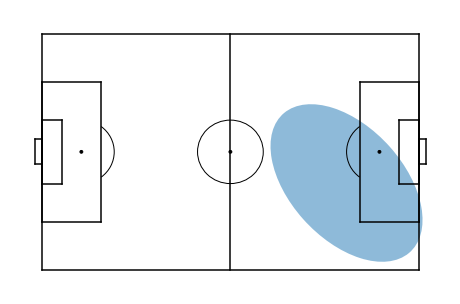

out 4


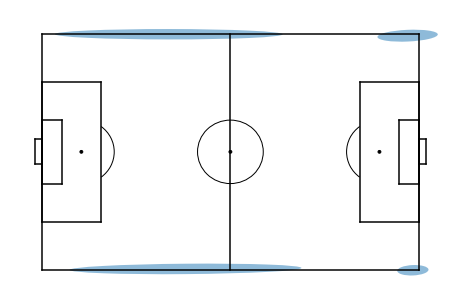

goal 1


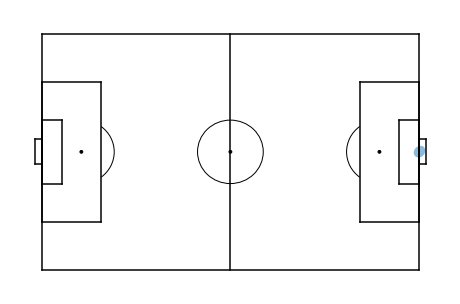

cross 2


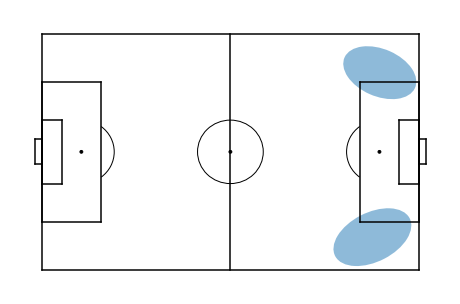

shot_penalty 1


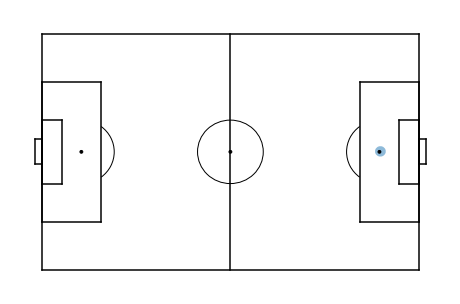

yellow_card 3


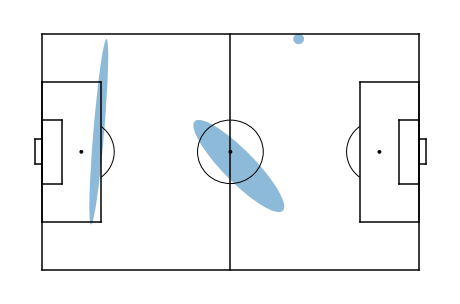

bad_touch 1


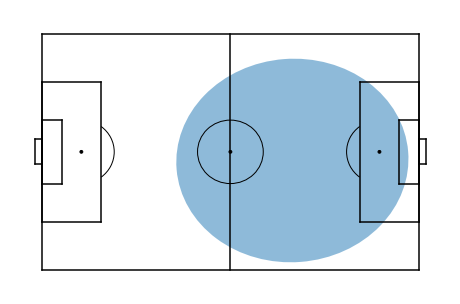

receival 6


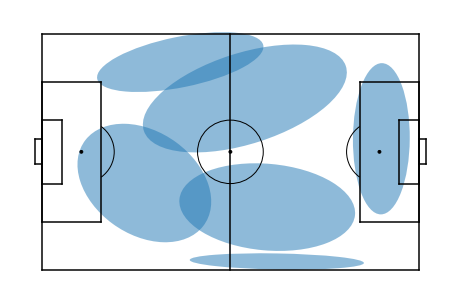

clearance 1


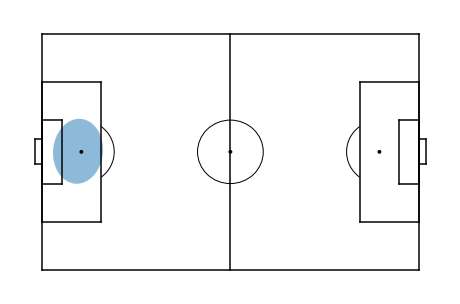

interception 2


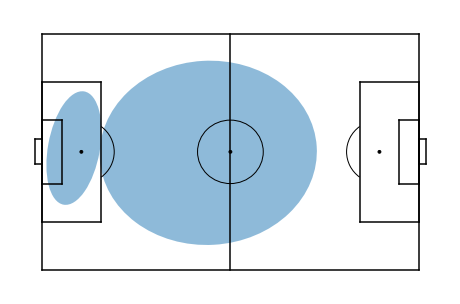

take_on 1


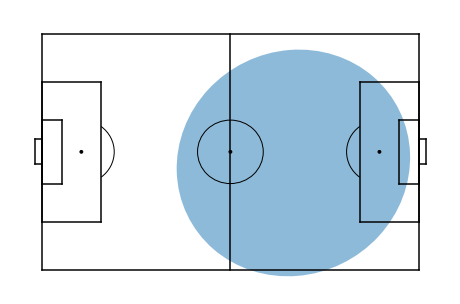

throw_in 2
throw_in_0 1
throw_in_1 2


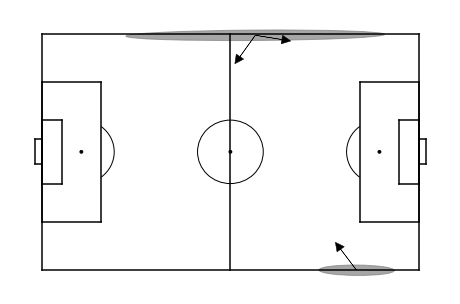

shot 1


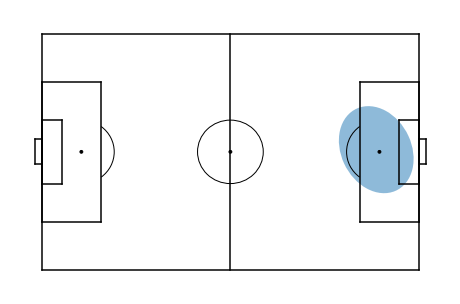

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


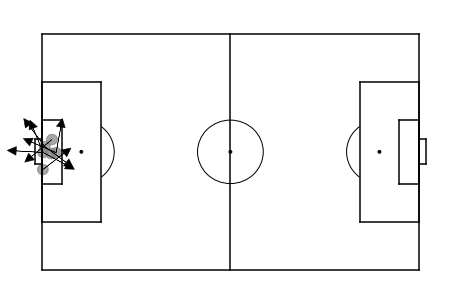

tackle 2


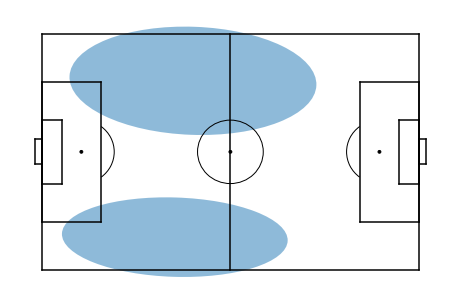

pass 4
pass_0 4
pass_1 1
pass_2 2
pass_3 2


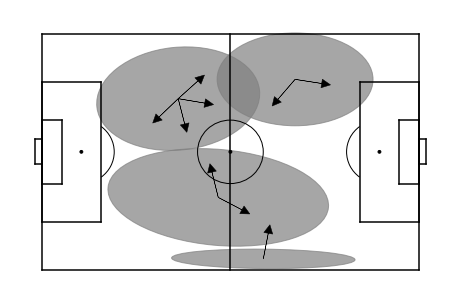

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


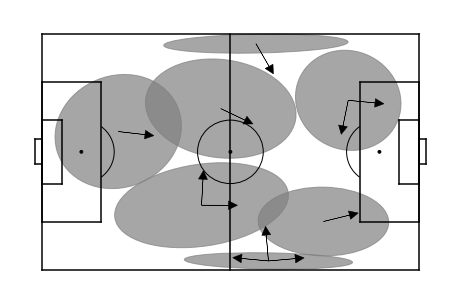

freekick 2


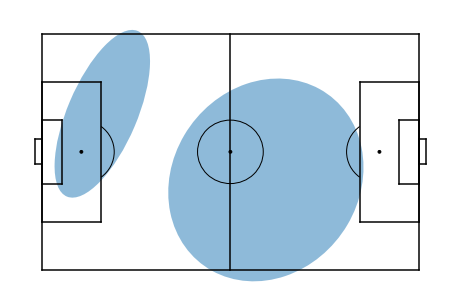

corner 2


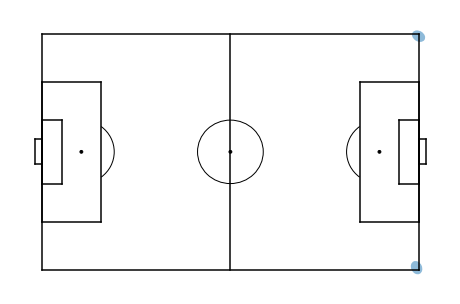

foul 1


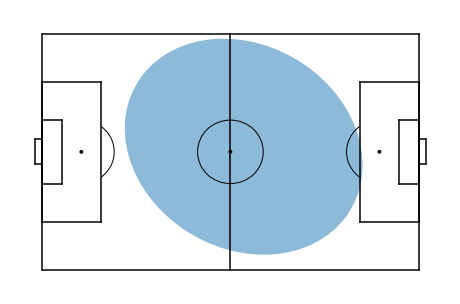

goalkick 1


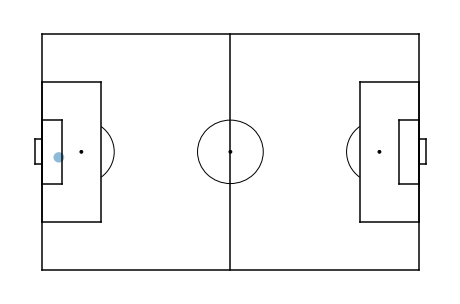

In [48]:
vis.show_all_models(loc_models,dir_models)

In [49]:
dir_weights = mix.probabilities(dir_models, a[["mov_angle_a0"]], loc_weights)

## Save direction models

In [50]:
with open('../data/soccermix_fifa_models.pkl','ab') as wfp:
    pickle.dump(dir_models, wfp)

In [51]:
data3 = open('../data/soccermix_fifa_dirweights.pkl', 'wb') 

s_dir_weights = dir_weights.astype(pd.SparseDtype("float", 0.0))
s_dir_weights.to_pickle(data3)

data3.close()

## Get final weights for full dataset

In [53]:
games = pd.read_hdf(spadl_h5,"games")

print("nb of games:", len(games))

nb of games: 64


In [55]:
with pd.HDFStore(spadl_h5) as spadlstore:
    all_actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a2 = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a2] = fs.play_left_to_right([a2],game.home_team_id)
        a2["is_home"] = a2.team_id == game.home_team_id
        all_actions.append(a2)
    all_actions = pd.concat(all_actions)
    all_actions = all_actions.merge(spadlstore["atomic_actiontypes"],how="left")
all_actions[:5]


0it [00:00, ?it/s]
5it [00:00, 49.11it/s]
11it [00:00, 50.85it/s]
17it [00:00, 52.17it/s]
23it [00:00, 53.79it/s]
29it [00:00, 53.71it/s]
35it [00:00, 54.11it/s]
41it [00:00, 54.69it/s]
47it [00:00, 54.77it/s]
53it [00:00, 54.77it/s]
64it [00:01, 53.76it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,type_name
0,7581.0,1.0,0,1.0,00:00:01.013,776.0,3043.0,52.941176,33.569620,-21.176471,3.443038,0,0,False,pass
1,7581.0,1.0,1,1.5,00:00:02.653,776.0,3027.0,31.764706,37.012658,-0.000000,-0.000000,23,0,False,receival
2,7581.0,1.0,2,2.0,00:00:02.653,776.0,3027.0,31.764706,37.012658,0.882353,-4.303797,21,0,False,dribble
3,7581.0,1.0,3,4.0,00:00:04.053,776.0,3027.0,32.647059,32.708861,52.058824,-12.911392,0,0,False,pass
4,7581.0,1.0,4,5.5,00:00:07.000,785.0,5468.0,20.294118,48.202532,0.000000,0.000000,10,0,True,interception


In [56]:
all_actions = simplify(all_actions)
all_actions = pd.concat([all_actions,fs.movement_polar(all_actions)],axis=1) # add polar movement direction
all_actions

,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,type_name,mov_d_a0,mov_angle_a0
0,7581.0,1.0,0,1.0,00:00:01.013,776.0,3043.0,52.941176,33.569620,-21.176471,3.443038,0,0,False,pass,21.454543,2.980415
1,7581.0,1.0,1,1.5,00:00:02.653,776.0,3027.0,31.764706,37.012658,-0.000000,-0.000000,23,0,False,receival,0.000000,0.000000
2,7581.0,1.0,2,2.0,00:00:02.653,776.0,3027.0,31.764706,37.012658,0.882353,-4.303797,21,0,False,dribble,4.393315,-1.368581
3,7581.0,1.0,3,4.0,00:00:04.053,776.0,3027.0,32.647059,32.708861,52.058824,-12.911392,0,0,False,pass,53.636043,-0.243110
4,7581.0,1.0,4,5.5,00:00:07.000,785.0,5468.0,20.294118,48.202532,0.000000,0.000000,10,0,True,interception,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,8656.0,4.0,3554,7458.0,00:19:19.323,785.0,3471.0,6.176471,37.012658,0.000000,0.000000,10,0,True,interception,0.000000,0.000000
194348,8656.0,4.0,3555,7459.0,00:19:19.323,785.0,3471.0,6.176471,37.012658,9.705882,13.772152,18,0,True,clearance,16.848630,0.956892
194349,8656.0,4.0,3556,7460.0,00:19:21.123,785.0,5474.0,15.882353,50.784810,0.000000,0.000000,23,0,True,receival,0.000000,0.000000
194350,8656.0,4.0,3557,7461.0,00:19:21.123,785.0,5474.0,15.882353,50.784810,0.000000,0.000000,21,0,True,dribble,0.000000,0.000000


In [57]:
all_cat_weights = cat_model.predict_proba(all_actions["type_name"])
X = all_actions[["x","y"]]
cat_weights = remove_outliers(X,all_cat_weights)

all_loc_weights = mix.probabilities(loc_models,all_actions[["x","y"]],all_cat_weights)

all_dir_weights = mix.probabilities(dir_models, all_actions[["mov_angle_a0"]], all_loc_weights)

../mixture.py:191: RuntimeWarning: invalid value encountered in true_divide
  probs = resp / resp.sum(axis=1)[:, np.newaxis]
../mixture.py:185: RuntimeWarning: invalid value encountered in greater
  pos_weights_idx = weights > self.tol


In [58]:
data1 = open('../data/soccermix_fifa_all_catweights.pkl', 'wb') 

s_cat_weights = all_cat_weights.astype(pd.SparseDtype("float", 0.0))
s_cat_weights.to_pickle(data1)

data1.close()

In [59]:
data2 = open('../data/soccermix_fifa_all_locweights.pkl', 'wb') 

s_loc_weights = all_loc_weights.astype(pd.SparseDtype("float", 0.0))
s_loc_weights.to_pickle(data2)

data2.close()

In [60]:
data3 = open('../data/soccermix_fifa_all_dirweights.pkl', 'wb') 

s_dir_weights = all_dir_weights.astype(pd.SparseDtype("float", 0.0))
s_dir_weights.to_pickle(data3)

data3.close()

In [61]:
data = '../data/soccermix_fifa_all_data.h5'
all_actions.to_hdf(data, "X")